## **Preparing data**

In [ ]:
##Libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import random
from urllib import request
import nltk
import requests
from bs4 import BeautifulSoup
import re
from urllib import request
import nltk
import pandas as pd
import random
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from nltk.corpus import stopwords


nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

##Fetching the text using the url
def text_gutenberg(url_txt):
    response = requests.get(url_txt)
    raw = response.text

    start_regex = r'\*\*\* START OF (THIS|THE) PROJECT GUTENBERG EBOOK'
    end_regex = r'\*\*\* END OF (THIS|THE) PROJECT GUTENBERG EBOOK'

    start_match = re.search(start_regex, raw)
    end_match = re.search(end_regex, raw)

    if start_match and end_match:
        beginning = start_match.end()
        end_position = end_match.start()
        text = raw[beginning:end_position]
        return text
    else:
        print(f"Start or end pattern not found in {url_txt}")
        return ""

#finding the text's title and author
def get_book_info(url_text):
    try:
        response = requests.get(url_text)
        soup = BeautifulSoup(response.text, 'html.parser')

        # Locating the title and author in the content
        content = soup.get_text()
        title_match = re.search(r'Title:\s*([^\n\r]+)', content)
        author_match = re.search(r'Author:\s*([^\n\r]+)', content)

        title = title_match.group(1).strip() if title_match else "Title not found"
        author = author_match.group(1).strip() if author_match else "Author not found"

        return title, author
    except Exception as e:
        return f"Error: {e}"

##Getting the tokens out of the text
def clean_tokens(token_list):
    cleaned = [re.sub('[^a-zA-Z]', ' ', token) for token in token_list if token.lower() not in stop_words]
    cleaned = [token.lower().strip() for token in cleaned if token.strip()]
    return cleaned


## Set a seed for reproducibility
random.seed(42)

#Helper function to make sure functions don't overlap
def get_non_overlapping_start_index(used_indices, record_length, total_length, max_attempts=1000):
    attempt = 0
    while attempt < max_attempts:
        start_index = random.randint(0, total_length - record_length)
        if all(start_index not in range(index, index + record_length) for index in used_indices):
            return start_index
        attempt += 1
    raise ValueError("Unable to find a non-overlapping start index. Consider reducing sample size or record length.")

##Creating the samples
def create_samples(url_txt, label, n_samples=200, record_length=100):
    text = text_gutenberg(url_txt)
    title, author = get_book_info(url_txt)

    words = text.split()
    total_length = len(words)
    used_indices = set()

    samples = []
    for _ in range(n_samples):
        start_index = get_non_overlapping_start_index(used_indices, record_length, total_length)
        used_indices.update(range(start_index, start_index + record_length))

        sample_words = words[start_index:start_index + record_length]
        sample_text = ' '.join(sample_words)

        tokens = nltk.word_tokenize(sample_text)
        cleaned_tokens = clean_tokens(tokens)

        samples.append({'Title': title, 'Author': author, 'Label': label, 'Tokens': cleaned_tokens})

    return samples

##Creating the dataframe
def create_dataframe(book_urls):
    all_samples = []

    for label, url in enumerate(book_urls, start=0):
        book_label = chr(97 + label)  # Generate labels a, b, c, ...
        book_samples = create_samples(url, book_label)
        all_samples.extend(book_samples)

    df = pd.DataFrame(all_samples)
    return df

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#Using 6 books of the fantasy genra
book_urls = ["https://www.gutenberg.org/cache/epub/68061/pg68061-images.html",
             "https://www.gutenberg.org/cache/epub/55/pg55-images.html",
             "https://www.gutenberg.org/cache/epub/7477/pg7477-images.html",
             "https://www.gutenberg.org/cache/epub/34219/pg34219-images.html",
             "https://www.gutenberg.org/cache/epub/10662/pg10662-images.html",
             "https://www.gutenberg.org/cache/epub/12753/pg12753-images.html"]
df = create_dataframe(book_urls)

df['genre'] = 'Fantasy'

df.head


<bound method NDFrame.head of                                            Title             Author Label  \
0                                Lud-in-the-Mist      Hope Mirrlees     a   
1                                Lud-in-the-Mist      Hope Mirrlees     a   
2                                Lud-in-the-Mist      Hope Mirrlees     a   
3                                Lud-in-the-Mist      Hope Mirrlees     a   
4                                Lud-in-the-Mist      Hope Mirrlees     a   
...                                          ...                ...   ...   
1195  The Legends of King Arthur and His Knights  Sir James Knowles     f   
1196  The Legends of King Arthur and His Knights  Sir James Knowles     f   
1197  The Legends of King Arthur and His Knights  Sir James Knowles     f   
1198  The Legends of King Arthur and His Knights  Sir James Knowles     f   
1199  The Legends of King Arthur and His Knights  Sir James Knowles     f   

                                             

In [ ]:
len(df)

1200

##**Preprocessing data**

In [ ]:
import pandas as pd
import re
from nltk.corpus import stopwords
nltk.download('wordnet')

##stemming removes suffixes of the word
def stemming(token_list):
  ps = nltk.stem.porter.PorterStemmer()
  stem_txt = [ps.stem(word) for word in token_list]
  return stem_txt

## Lemmatisation (convert the word into root word)
def lemmatisation(token_list):
  lem = nltk.stem.wordnet.WordNetLemmatizer()
  lem_txt = [lem.lemmatize(word) for word in token_list]
  return lem_txt


df['Tokens'] = df['Tokens'].apply(stemming)
df['Tokens'] = df['Tokens'].apply(lemmatisation)
df.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Title,Author,Label,Tokens,genre
0,Lud-in-the-Mist,Hope Mirrlees,a,"[hazel, time, protest, gave, smack, kiss, lip,...",Fantasy
1,Lud-in-the-Mist,Hope Mirrlees,a,"[glass, said, briskli, leer, let, s, go, busi,...",Fantasy
2,Lud-in-the-Mist,Hope Mirrlees,a,"[court, jester, commit, suicid, free, began, w...",Fantasy
3,Lud-in-the-Mist,Hope Mirrlees,a,"[div, class, poetri, div, class, stanza, div, ...",Fantasy
4,Lud-in-the-Mist,Hope Mirrlees,a,"[would, comfort, talk, man, boat, himself if, ...",Fantasy


## **Feature Engineering**

### Word count

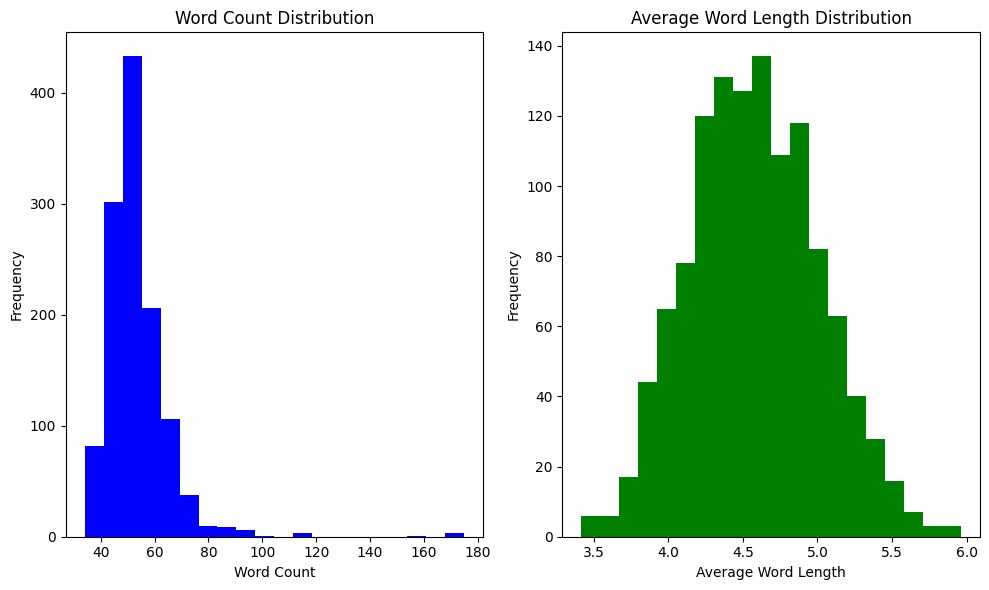

In [ ]:
import matplotlib.pyplot as plt


# Calculating word count and average word length
df['word_count'] = df['Tokens'].apply(lambda x: len(x))
df['char_count'] = df['Tokens'].apply(lambda x: sum(len(word) for word in x))
df['avg_word_length'] = df['char_count'] / df['word_count']

# Displaying first few rows
df[['Tokens', 'word_count', 'avg_word_length']].head()

# Visualization
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.hist(df['word_count'], bins=20, color='blue')
plt.title('Word Count Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(df['avg_word_length'], bins=20, color='green')
plt.title('Average Word Length Distribution')
plt.xlabel('Average Word Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

<ipython-input-37-23b1b6a059c1>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Author', y='word_count', data=df, palette='Set2')


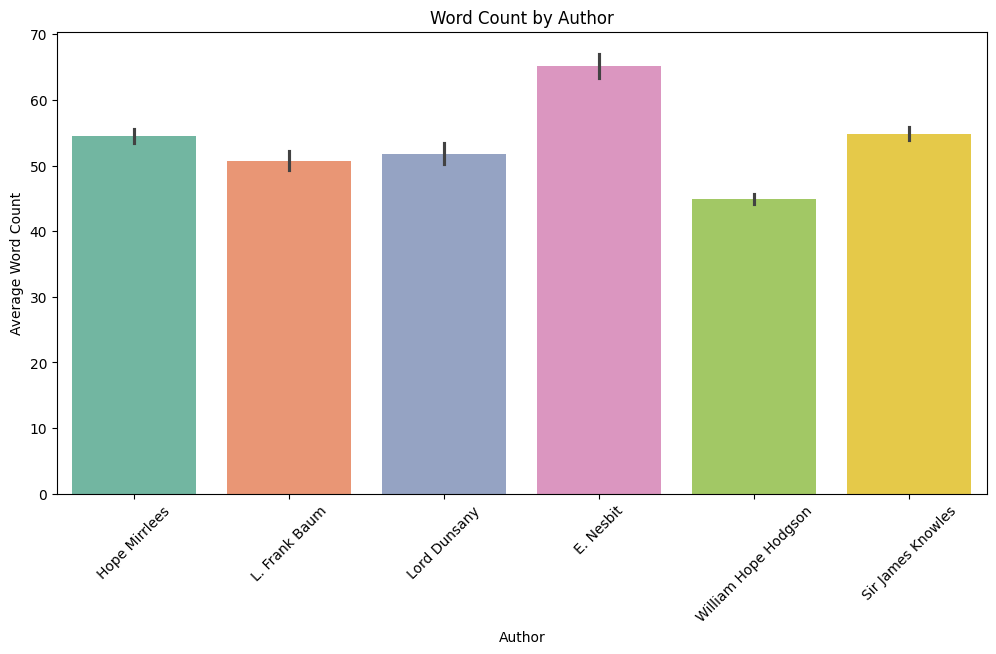

<ipython-input-37-23b1b6a059c1>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Author', y='avg_word_length', data=df, palette='Set3')


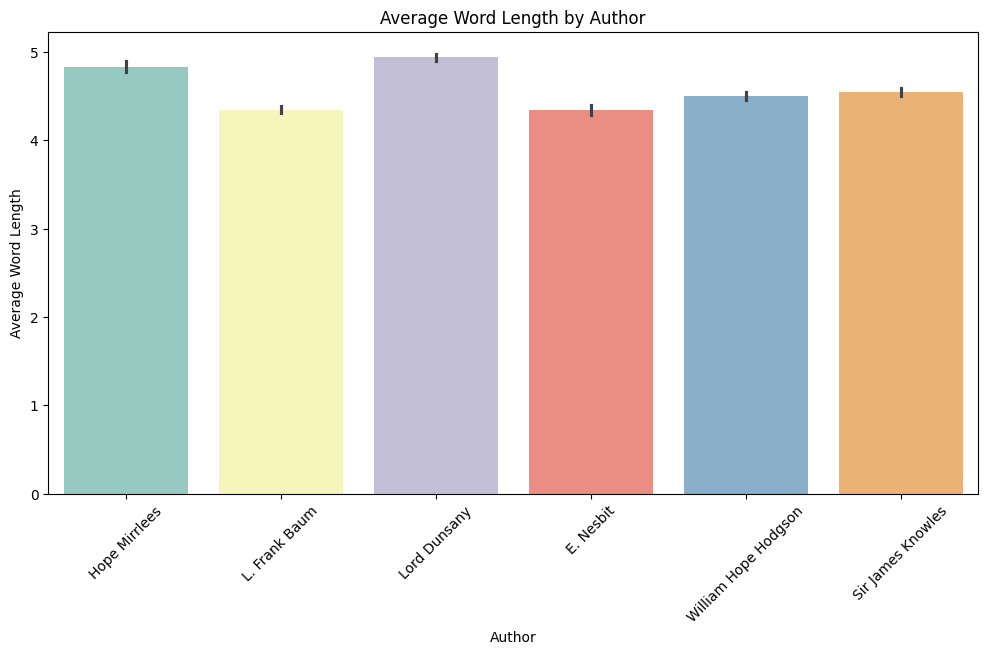

In [ ]:
import seaborn as sns

# Visualization of Word Count by Author
plt.figure(figsize=(12, 6))
sns.barplot(x='Author', y='word_count', data=df, palette='Set2')
plt.xticks(rotation=45)
plt.title('Word Count by Author')
plt.xlabel('Author')
plt.ylabel('Average Word Count')
plt.show()

# Visualization of Average Word Length by Author
plt.figure(figsize=(12, 6))
sns.barplot(x='Author', y='avg_word_length', data=df, palette='Set3')
plt.xticks(rotation=45)
plt.title('Average Word Length by Author')
plt.xlabel('Author')
plt.ylabel('Average Word Length')
plt.show()


### Sentiment and subjectivity score

<ipython-input-10-55dd49ab12df>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Author', y='sentiment', data=df, palette='viridis')


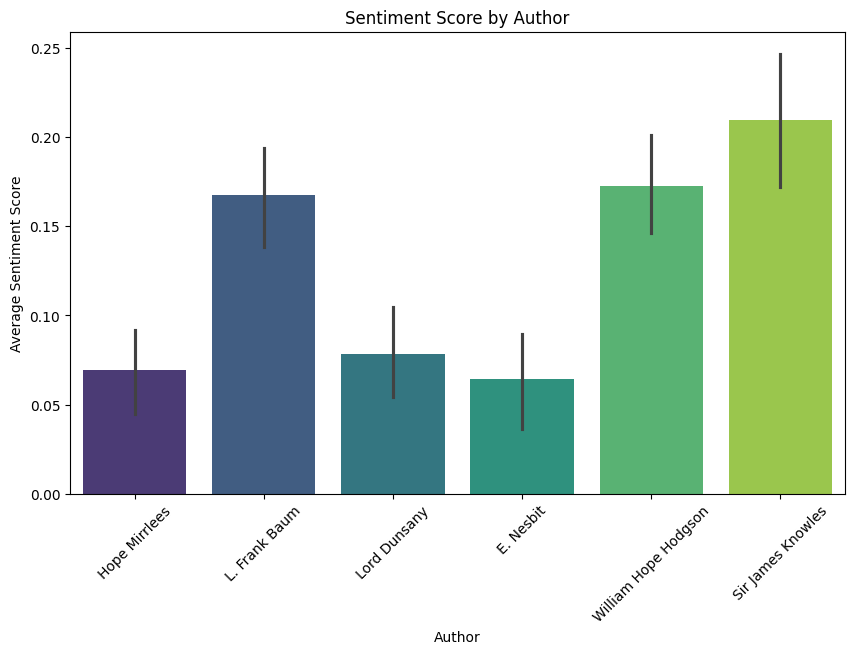

In [ ]:
from textblob import TextBlob

# Calculating sentiment score
df["sentiment"] = df['Tokens'].apply(lambda x: TextBlob(' '.join(x)).sentiment.polarity)
df[['Tokens', 'sentiment']].head()

# Visualization
plt.figure(figsize=(10, 6))
sns.barplot(x='Author', y='sentiment', data=df, palette='viridis')
plt.xticks(rotation=45)
plt.title('Sentiment Score by Author')
plt.xlabel('Author')
plt.ylabel('Average Sentiment Score')
plt.show()

<ipython-input-11-f42ac289176a>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Author', y='subjectivity_score', data=df, palette='pastel')


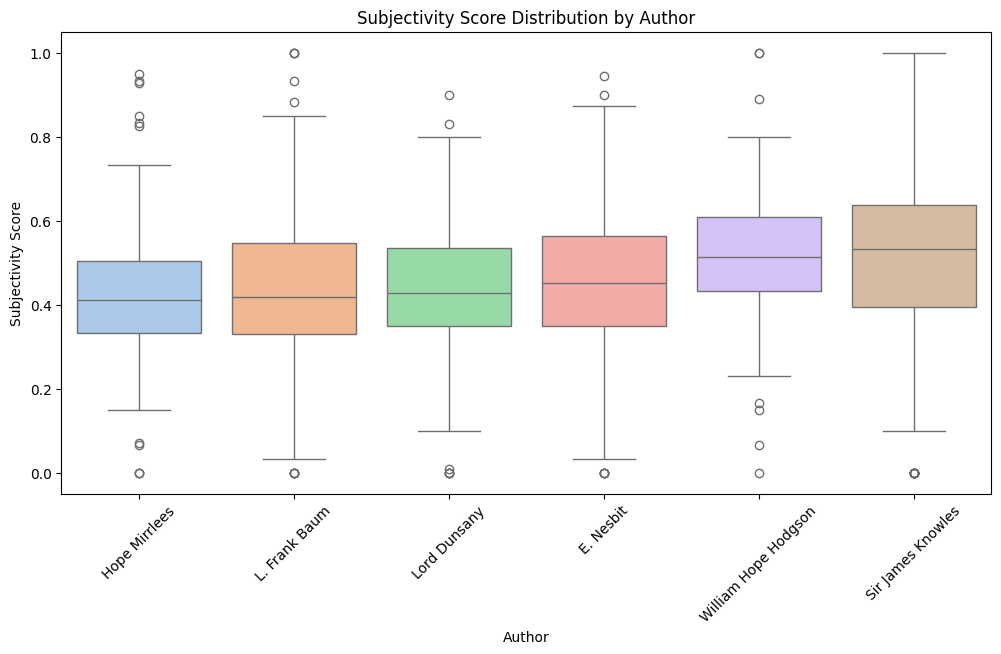

In [ ]:
# Calculating subjectivity score
df["subjectivity_score"] = df['Tokens'].apply(lambda x: TextBlob(' '.join(x)).sentiment.subjectivity)
df[['Tokens', 'subjectivity_score']].head()
# Box Plot Visualization of Subjectivity Score by Author
plt.figure(figsize=(12, 6))
sns.boxplot(x='Author', y='subjectivity_score', data=df, palette='pastel')
plt.xticks(rotation=45)
plt.title('Subjectivity Score Distribution by Author')
plt.xlabel('Author')
plt.ylabel('Subjectivity Score')
plt.show()

### Part of speech

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


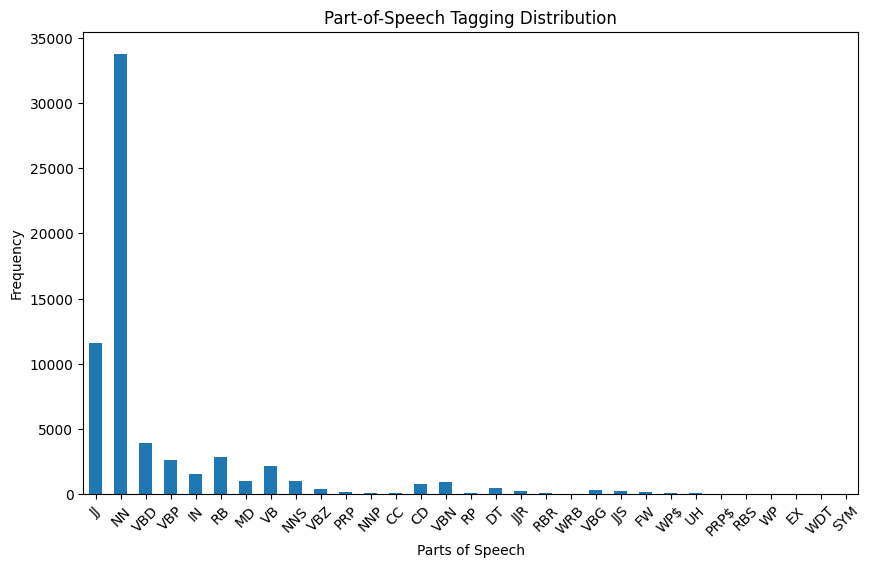

In [ ]:
nltk.download('averaged_perceptron_tagger')
import matplotlib.pyplot as plt
import pandas as pd
from nltk import pos_tag
from collections import Counter

# Function to perform POS tagging
def pos_tagging(tokens):
    return pos_tag(tokens)

# Apply POS tagging
df['POS_tags'] = df['Tokens'].apply(pos_tagging)

# Flattening the list of tuples and counting
pos_counts = Counter([pos for sublist in df['POS_tags'] for _, pos in sublist])

# Visualization
plt.figure(figsize=(10, 6))
pd.Series(pos_counts).plot(kind='bar')
plt.title('Part-of-Speech Tagging Distribution')
plt.xlabel('Parts of Speech')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

###**Word Cloud**

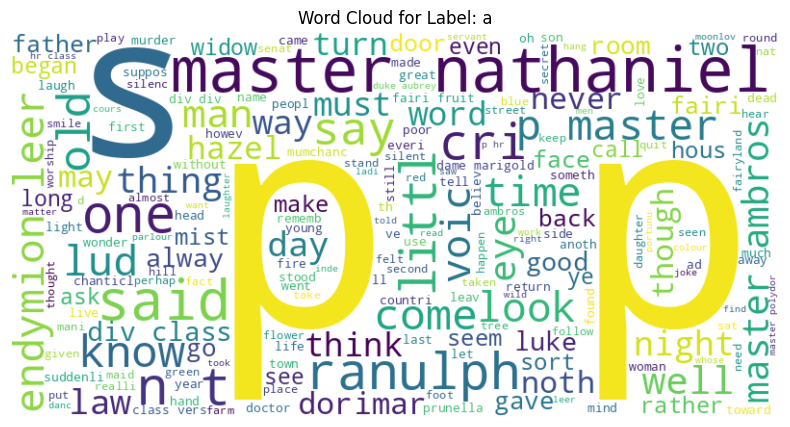

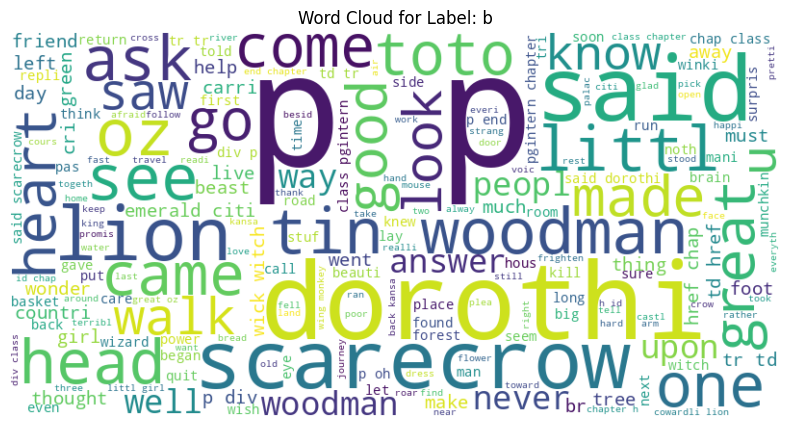

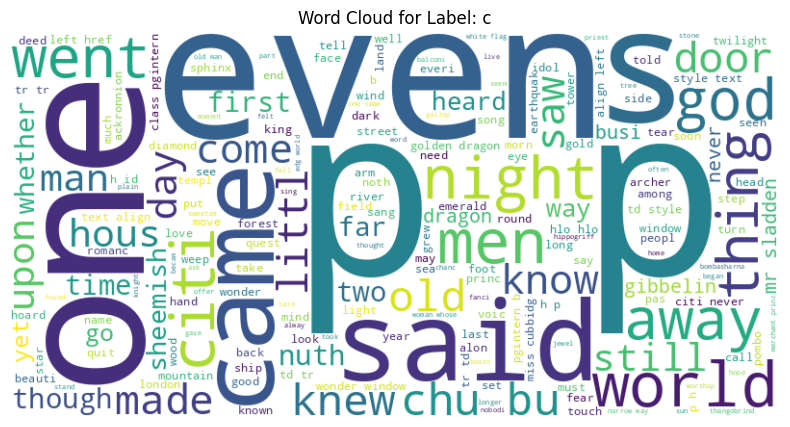

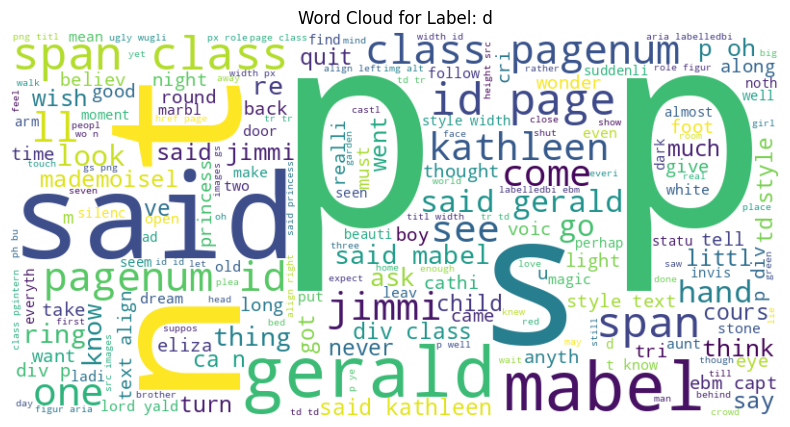

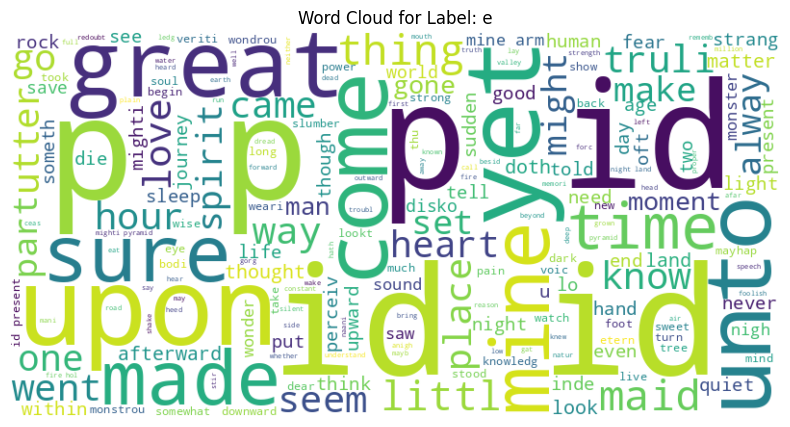

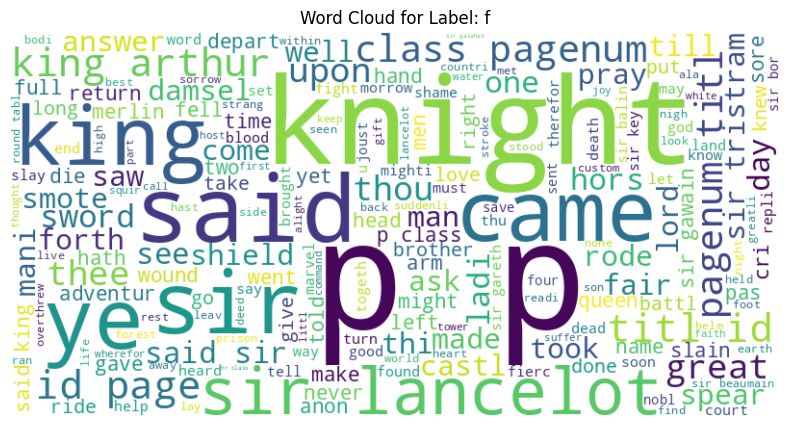

In [ ]:
!pip install wordcloud

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to create a word cloud
def create_word_cloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis("off")
    plt.show()

# Creating word clouds for each book/author
for label in df['Label'].unique():
    # Concatenate all samples for a given label
    aggregated_text = ' '.join(df[df['Label'] == label]['Text'])
    create_word_cloud(aggregated_text, f"Word Cloud for Label: {label}")

##**n_gram**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
# Convert list of tokens to strings
df['text'] = df['Tokens'].apply(lambda x: ' '.join(x))

# Create n-gram features
vectorizer = CountVectorizer(ngram_range=(1, 2))
X_ngrams = vectorizer.fit_transform(df['text'])
y = df['Author'].values


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_ngrams, y, test_size=0.2, random_state=42)

In [ ]:
import numpy as np
svm_model = SVC()
svm_model.fit(X_train, y_train)
svm_scores = cross_val_score(svm_model, X_ngrams, y, cv=10)
print("SVM Accuracy:", np.mean(svm_scores))

SVM Accuracy: 0.9616666666666666


In [ ]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_scores = cross_val_score(rf_model, X_ngrams, y, cv=10)
print("Random Forest Accuracy:", np.mean(rf_scores))

Random Forest Accuracy: 0.9733333333333333


In [ ]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
knn_scores = cross_val_score(knn_model, X_ngrams, y, cv=10)
print("KNN Accuracy:", np.mean(knn_scores))

KNN Accuracy: 0.6058333333333332


In [ ]:
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
nb_scores = cross_val_score(nb_model, X_ngrams, y, cv=10)
print("NB Accuracy:", np.mean(nb_scores))

NB Accuracy: 0.9958333333333333


In [ ]:
sgd_model = SGDClassifier()
sgd_model.fit(X_train, y_train)
sgd_scores = cross_val_score(sgd_model, X_ngrams, y, cv=10)
print("SGD Accuracy:", np.mean(sgd_scores))

SGD Accuracy: 0.9708333333333332


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
import numpy as np
import pandas as pd


# Initialize the models
svm_model = SVC()
rf_model = RandomForestClassifier()
knn_model = KNeighborsClassifier()
nb_model = MultinomialNB()
sgd_model = SGDClassifier()

# Function to perform cross-validation and calculate average performance metrics
def evaluate_model_with_cv(model, X, y, cv_folds):
    metrics = {
        'accuracy': cross_val_score(model, X, y, cv=cv_folds, scoring='accuracy').mean(),
        'precision': cross_val_score(model, X, y, cv=cv_folds, scoring=make_scorer(precision_score, average='weighted')).mean(),
        'recall': cross_val_score(model, X, y, cv=cv_folds, scoring=make_scorer(recall_score, average='weighted')).mean(),
        'f1_score': cross_val_score(model, X, y, cv=cv_folds, scoring=make_scorer(f1_score, average='weighted')).mean(),
    }
    return metrics

# Dictionary to store the performance of each model
models_performance = {}

# Perform 10-fold cross-validation and store their performance
for name, model in [('SVM', svm_model), ('Random Forest', rf_model), ('KNN', knn_model), ('NB', nb_model), ('SGD',sgd_model)]:
    models_performance[name] = evaluate_model_with_cv(model, X_ngrams, y, 10)

# Convert the performance metrics into a DataFrame for display
performance_df = pd.DataFrame(models_performance).T

# Print the average performance metrics from cross-validation
print(performance_df)


               accuracy  precision    recall  f1_score
SVM            0.961667   0.964183  0.961667  0.961592
Random Forest  0.968333   0.976294  0.970000  0.972694
KNN            0.605833   0.803898  0.605833  0.586701
NB             0.995833   0.996032  0.995833  0.995831
SGD            0.972500   0.972971  0.975833  0.974954


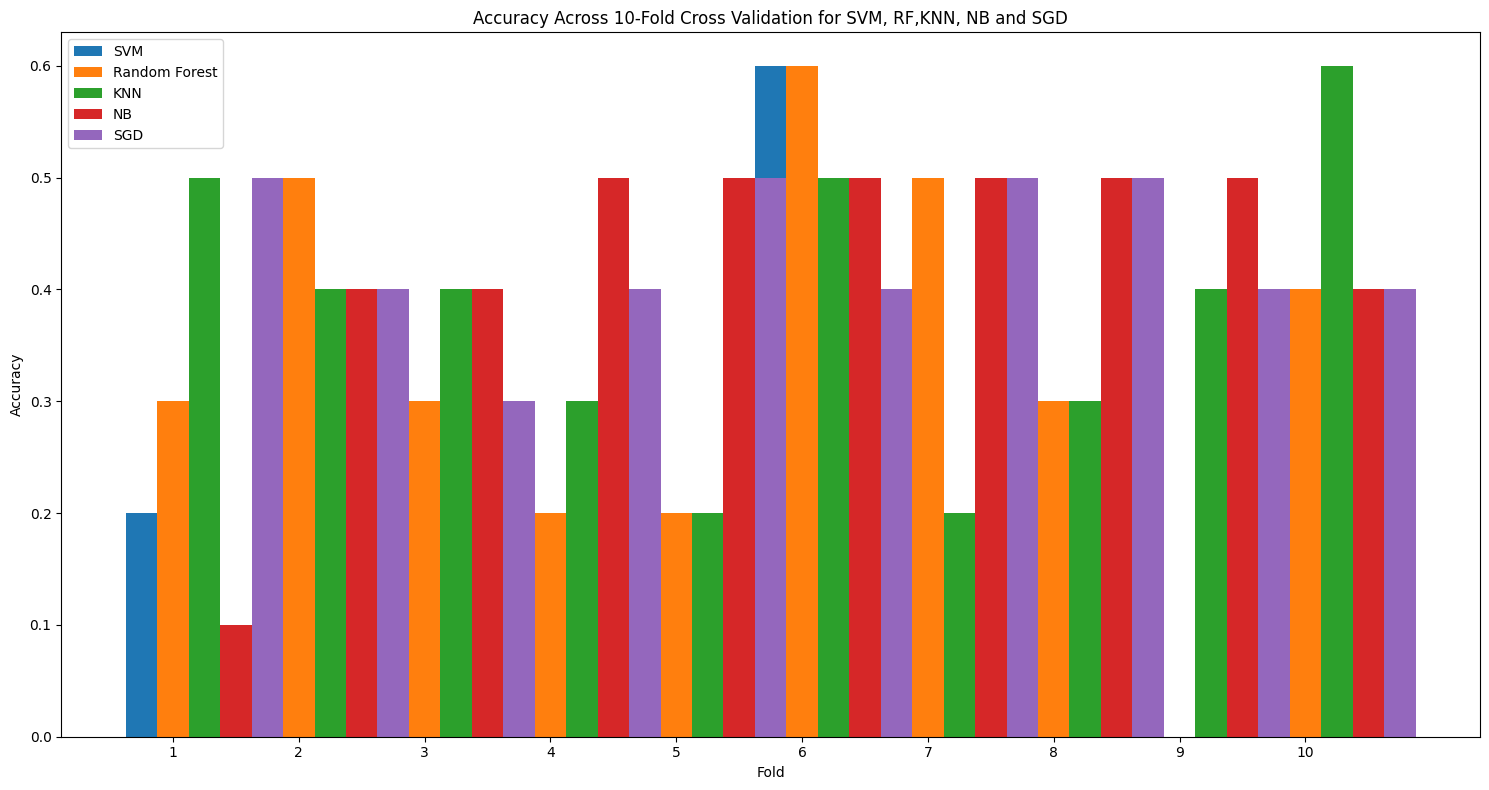

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Initialize the models
svm_model = SVC()
rf_model = RandomForestClassifier()
knn_model = KNeighborsClassifier()
nb_model = MultinomialNB()
sgd_model = SGDClassifier()

# Modified function to return accuracies for each fold
def evaluate_model_with_cv(model, X, y, cv_folds):
    accuracies = cross_val_score(model, X, y, cv=cv_folds, scoring='accuracy')
    return accuracies

# Assuming X_ngrams and y are defined in your dataset
# Replace these with your actual data
X_ngrams = np.random.rand(100, 5)  # Dummy data
y = np.random.randint(0, 2, 100)   # Dummy data

# Dictionary to store the accuracies for each fold of each model
models_fold_accuracies = {}

# Perform 10-fold cross-validation and store their accuracies for each fold
for name, model in [('SVM', svm_model), ('Random Forest', rf_model), ('KNN', knn_model), ('NB', nb_model), ('SGD',sgd_model)]:
    models_fold_accuracies[name] = evaluate_model_with_cv(model, X_ngrams, y, 10)

# Plotting the accuracies for each fold
bar_width = 0.25
index = np.arange(10)  # 10 folds

plt.figure(figsize=(15, 8))
plt.bar(index, models_fold_accuracies['SVM'], width=bar_width, label='SVM')
plt.bar(index + bar_width, models_fold_accuracies['Random Forest'], width=bar_width, label='Random Forest')
plt.bar(index + 2 * bar_width, models_fold_accuracies['KNN'], width=bar_width, label='KNN')
plt.bar(index + 3 * bar_width, models_fold_accuracies['NB'], width=bar_width, label='NB')
plt.bar(index + 4 * bar_width, models_fold_accuracies['SGD'], width=bar_width, label='SGD')


plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Accuracy Across 10-Fold Cross Validation for SVM, RF,KNN, NB and SGD')
plt.xticks(index + bar_width, range(1, 11))
plt.legend()
plt.tight_layout()
plt.show()


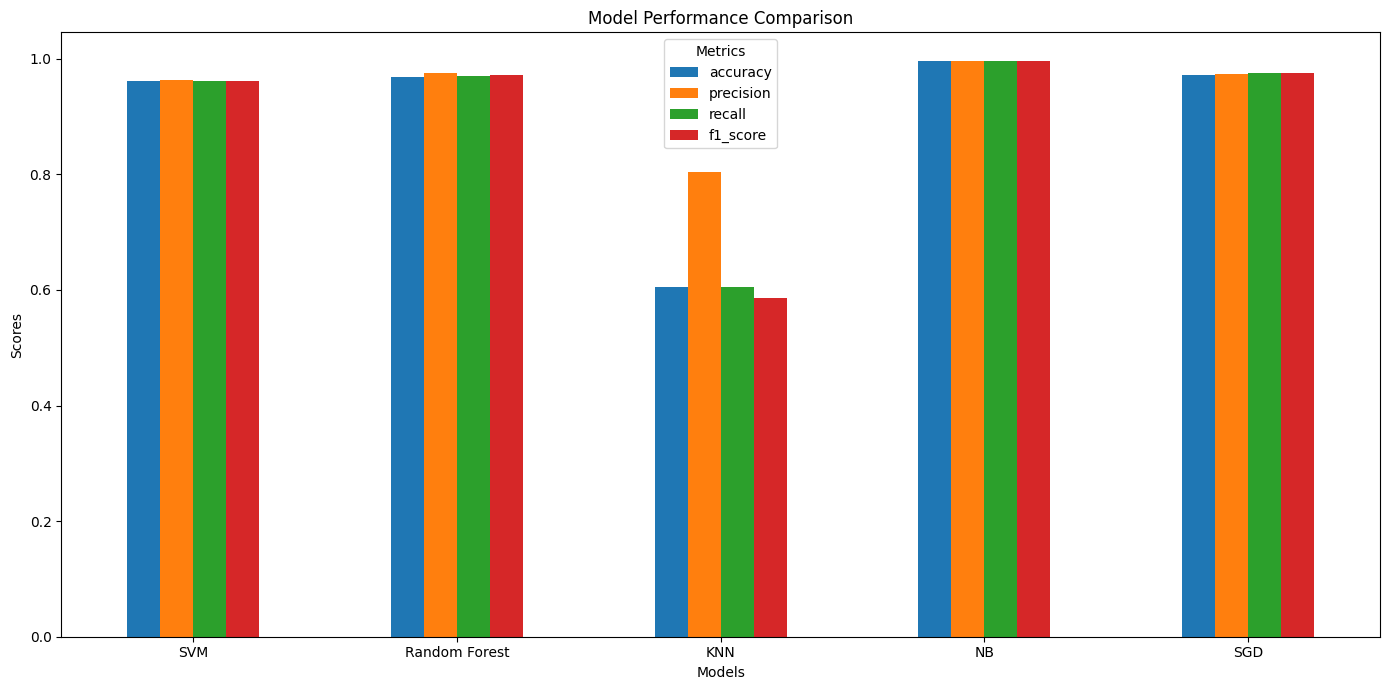

In [ ]:
import matplotlib.pyplot as plt

performance_df.plot(kind='bar', figsize=(14, 7))

plt.title('Model Performance Comparison')
plt.ylabel('Scores')
plt.xlabel('Models')
plt.legend(title='Metrics')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


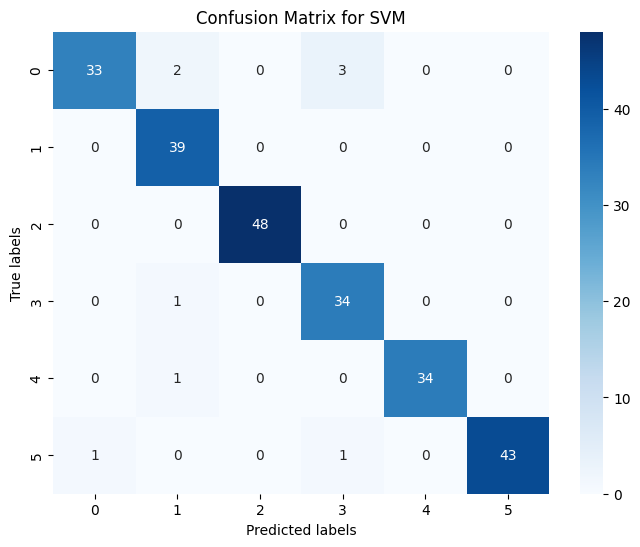

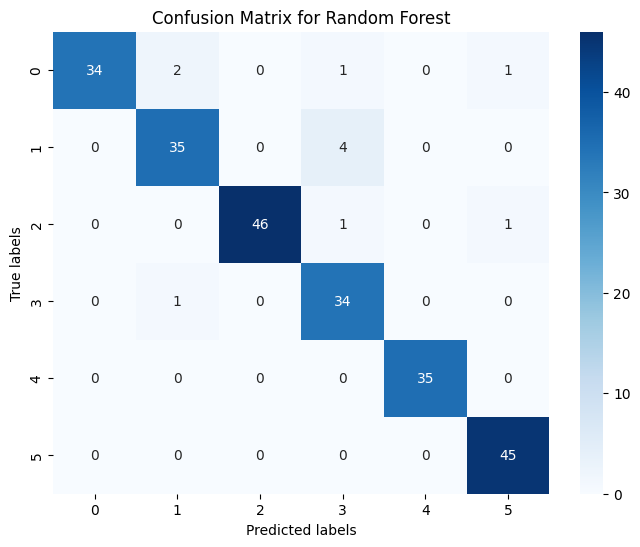

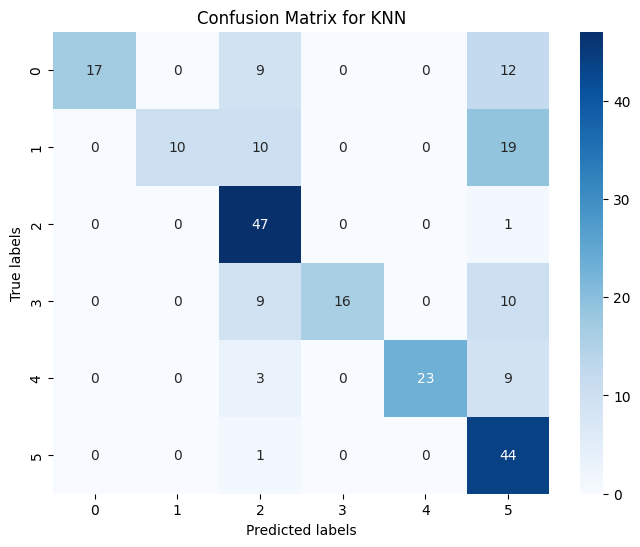

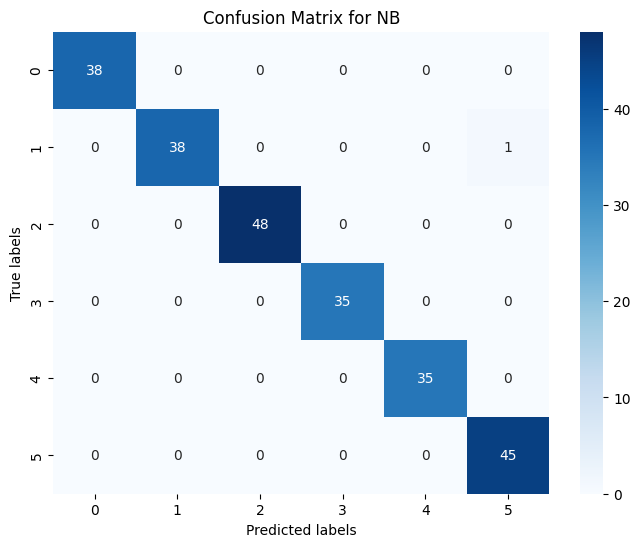

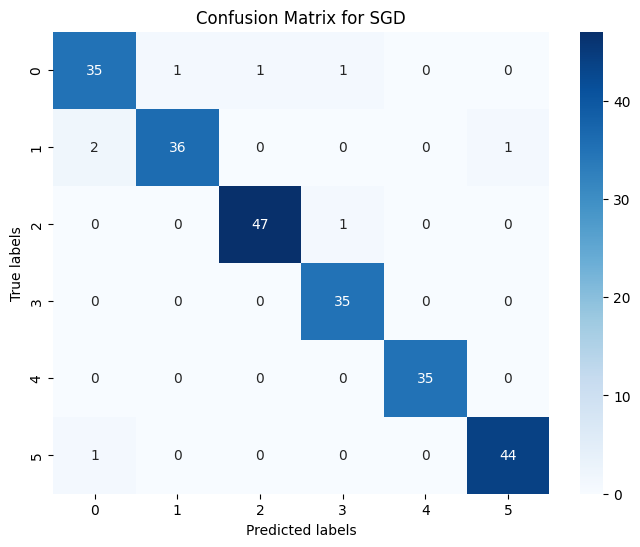

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming X_train, y_train, X_test, and y_test are already defined

def plot_confusion_matrix(y_test, y_pred, model_name):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

models = {
    'SVM': svm_model,
    'Random Forest': rf_model,
    'KNN': knn_model,
    'NB' : nb_model,
    'SGD': sgd_model
}

for name, model in models.items():
    # Here, we fit the model and predict in the same step for plotting
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    plot_confusion_matrix(y_test, y_pred, name)


In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from mlxtend.evaluate import bias_variance_decomp

# If y_train and y_test are not numeric, use LabelEncoder to convert them
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

def compare_models_bias_variability(models, X_train, y_train, X_test, y_test):
    for name, model in models.items():
        print(f"Evaluating: {name}")

        # Performing bias-variance decomposition
        avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
            model, X_train, y_train, X_test, y_test, loss='0-1_loss', num_rounds=200, random_seed=42)

        # Printing the results
        print(f"Model - {name}")
        print(f"Average Expected loss: {avg_expected_loss:.3f}")
        print(f'Average bias: {avg_bias:.3f}')
        print(f'Average variance: {avg_var:.3f}')
        print("----------------------------------------------")

# Define your models here
models = {
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier(),
    "KNN": KNeighborsClassifier(),
    "NB" : MultinomialNB(),
    "SGD" : SGDClassifier()
}

# Call the function with encoded labels
compare_models_bias_variability(models, X_train, y_train_encoded, X_test, y_test_encoded)


Evaluating: SVM
Model - SVM
Average Expected loss: 0.059
Average bias: 0.042
Average variance: 0.035
----------------------------------------------
Evaluating: Random Forest
Model - Random Forest
Average Expected loss: 0.063
Average bias: 0.042
Average variance: 0.042
----------------------------------------------
Evaluating: KNN
Model - KNN
Average Expected loss: 0.392
Average bias: 0.375
Average variance: 0.182
----------------------------------------------
Evaluating: NB
Model - NB
Average Expected loss: 0.015
Average bias: 0.008
Average variance: 0.014
----------------------------------------------
Evaluating: SGD
Model - SGD
Average Expected loss: 0.051
Average bias: 0.013
Average variance: 0.045
----------------------------------------------


###**BOW**

SVM Accuracy: 0.9674999999999999
Random Forest Accuracy: 0.9724999999999999
KNN Accuracy: 0.7441666666666666
NB Accuracy: 0.9924999999999999
SGD Accuracy: 0.9724999999999999
               accuracy  precision    recall  f1_score
SVM            0.967500   0.969428  0.967500  0.967408
Random Forest  0.965833   0.970420  0.966667  0.967518
KNN            0.744167   0.847962  0.744167  0.746137
NB             0.992500   0.992857  0.992500  0.992495
SGD            0.970000   0.967037  0.972500  0.974084


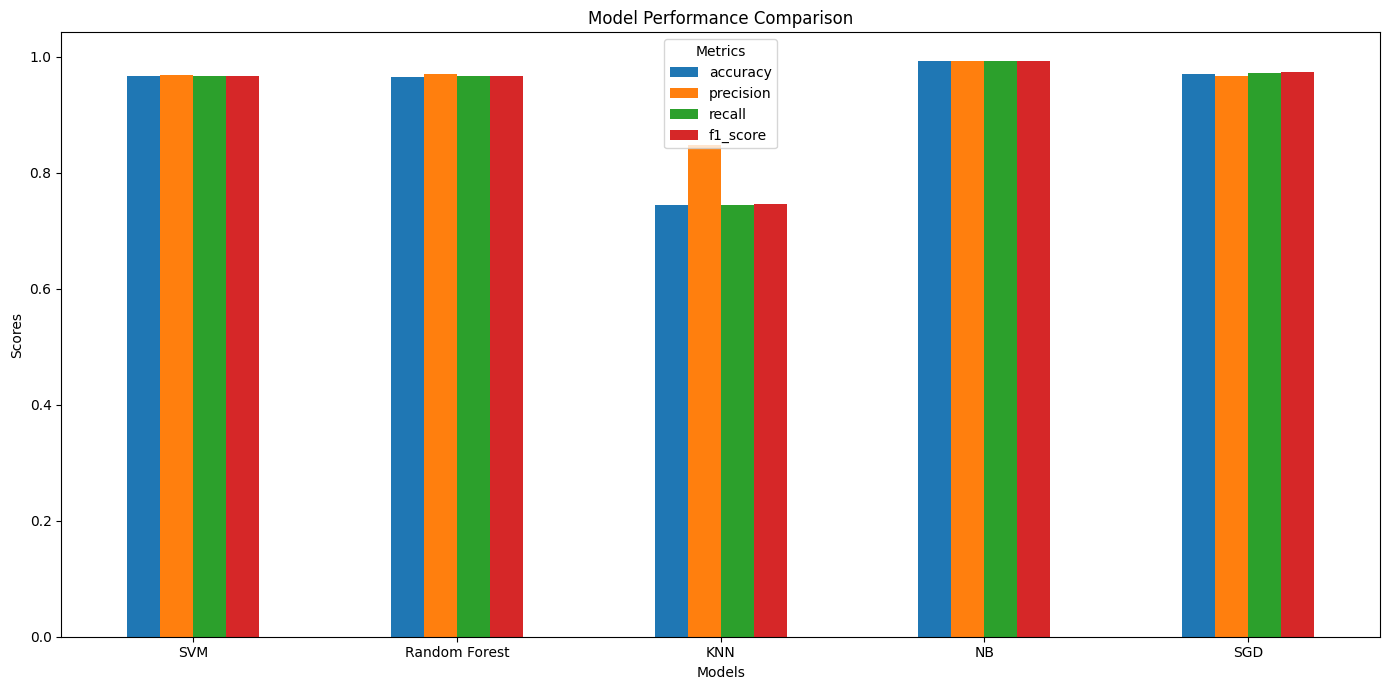

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
import numpy as np

# Joining the tokens back into a single string
df['Text'] = df['Tokens'].apply(lambda x: ' '.join(x))

vectorizer = CountVectorizer()
X_bow = vectorizer.fit_transform(df['Text'])
y = LabelEncoder().fit_transform(df['Author'])  # Encoding the labels for model training

from sklearn.model_selection import train_test_split

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_bow, y, test_size=0.2, random_state=42)



#10-fold cross validation:

import numpy as np
svm_model = SVC()
svm_model.fit(X_train, y_train)
svm_scores = cross_val_score(svm_model, X_bow, y, cv=10)
print("SVM Accuracy:", np.mean(svm_scores))


rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_scores = cross_val_score(rf_model, X_bow, y, cv=10)
print("Random Forest Accuracy:", np.mean(rf_scores))


knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
knn_scores = cross_val_score(knn_model, X_bow, y, cv=10)
print("KNN Accuracy:", np.mean(knn_scores))

nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
nb_scores = cross_val_score(nb_model,  X_bow, y, cv=10)
print("NB Accuracy:", np.mean(nb_scores))

sgd_model = SGDClassifier()
sgd_model.fit(X_train, y_train)
sgd_scores = cross_val_score(sgd_model,  X_bow, y, cv=10)
print("SGD Accuracy:", np.mean(sgd_scores))

#svm_model = SVC(probability=True)  # For ROC-AUC



from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
import numpy as np
import pandas as pd

# Initialize the models
svm_model = SVC()
rf_model = RandomForestClassifier()
knn_model = KNeighborsClassifier()
nb_model = MultinomialNB()
sgd_model = SGDClassifier()

# Function to perform cross-validation and calculate average performance metrics
def evaluate_model_with_cv(model, X, y, cv_folds):
    metrics = {
        'accuracy': cross_val_score(model, X, y, cv=cv_folds, scoring='accuracy').mean(),
        'precision': cross_val_score(model, X, y, cv=cv_folds, scoring=make_scorer(precision_score, average='weighted')).mean(),
        'recall': cross_val_score(model, X, y, cv=cv_folds, scoring=make_scorer(recall_score, average='weighted')).mean(),
        'f1_score': cross_val_score(model, X, y, cv=cv_folds, scoring=make_scorer(f1_score, average='weighted')).mean(),
    }
    return metrics

# Dictionary to store the performance of each model
models_performance = {}

# Perform 10-fold cross-validation and store their performance
for name, model in [('SVM', svm_model), ('Random Forest', rf_model), ('KNN', knn_model), ('NB', nb_model), ('SGD',sgd_model)]:
    models_performance[name] = evaluate_model_with_cv(model,  X_bow, y, 10)

# Convert the performance metrics into a DataFrame for display
performance_df = pd.DataFrame(models_performance).T

# Print the average performance metrics from cross-validation
print(performance_df)

# # Initialize the models
# svm_model = SVC()
# rf_model = RandomForestClassifier()
# knn_model = KNeighborsClassifier()

# # Function to perform cross-validation and calculate average performance metrics
# def evaluate_model_with_cv(model, X, y, cv_folds):
#     metrics = {
#         'accuracy': cross_val_score(model, X, y, cv=cv_folds, scoring='accuracy').mean(),
#         'precision': cross_val_score(model, X, y, cv=cv_folds, scoring=make_scorer(precision_score, average='weighted')).mean(),
#         'recall': cross_val_score(model, X, y, cv=cv_folds, scoring=make_scorer(recall_score, average='weighted')).mean(),
#         'f1_score': cross_val_score(model, X, y, cv=cv_folds, scoring=make_scorer(f1_score, average='weighted')).mean(),
#     }
#     return metrics

# # Dictionary to store the performance of each model
# models_performance = {}

# # Perform 10-fold cross-validation and store their performance
# for name, model in [('SVM', svm_model), ('Random Forest', rf_model), ('KNN', knn_model)]:
#     models_performance[name] = evaluate_model_with_cv(model, X_bow, y, 10)

# # Convert the performance metrics into a DataFrame for display
# performance_df = pd.DataFrame(models_performance).T

# # Print the average performance metrics from cross-validation
# print(performance_df)

import matplotlib.pyplot as plt

performance_df.plot(kind='bar', figsize=(14, 7))

plt.title('Model Performance Comparison')
plt.ylabel('Scores')
plt.xlabel('Models')
plt.legend(title='Metrics')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


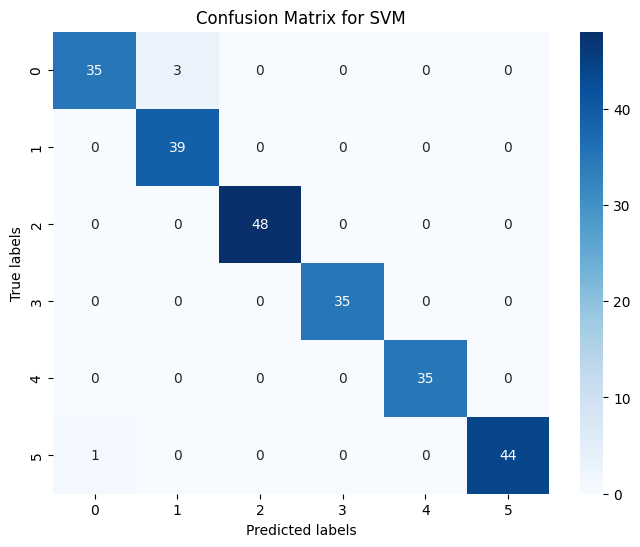

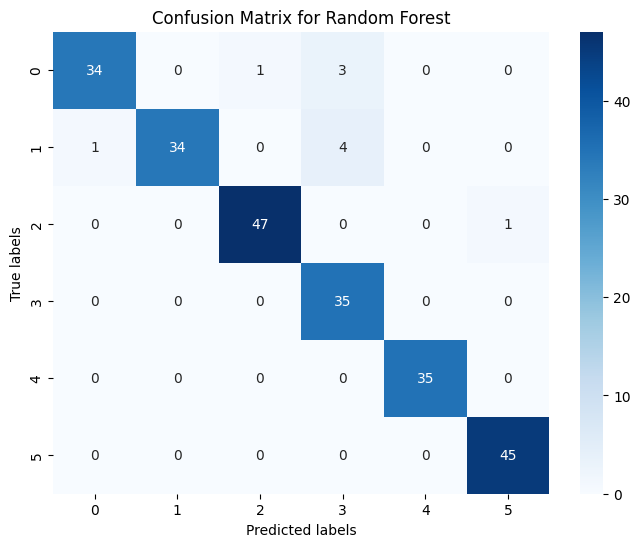

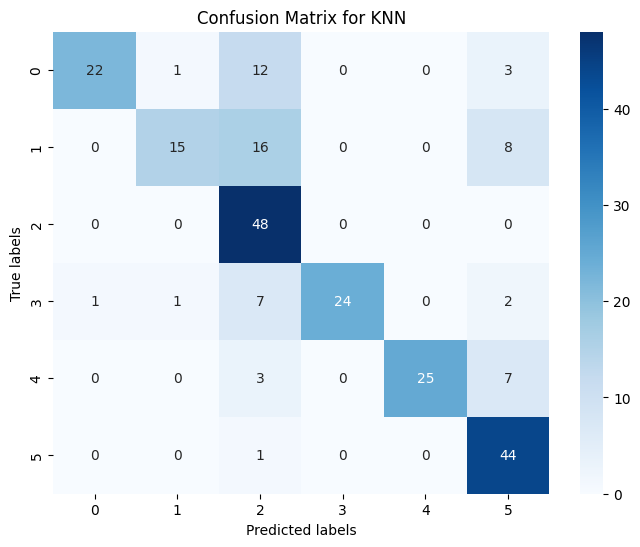

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming X_train, y_train, X_test, and y_test are already defined

def plot_confusion_matrix(y_test, y_pred, model_name):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

models = {
    'SVM': svm_model,
    'Random Forest': rf_model,
    'KNN': knn_model,
    'NB' : nb_model,
    'SGD': sgd_model
}

for name, model in models.items():
    # Here, we fit the model and predict in the same step for plotting
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    plot_confusion_matrix(y_test, y_pred, name)

In [ ]:
# from sklearn.svm import SVC
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.preprocessing import LabelEncoder
# from mlxtend.evaluate import bias_variance_decomp

# # If y_train and y_test are not numeric, use LabelEncoder to convert them
# label_encoder = LabelEncoder()
# y_train_encoded = label_encoder.fit_transform(y_train)
# y_test_encoded = label_encoder.transform(y_test)

# def compare_models_bias_variability(models, X_train, y_train, X_test, y_test):
#     for name, model in models.items():
#         print(f"Evaluating: {name}")

#         # Performing bias-variance decomposition
#         avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
#             model, X_train, y_train, X_test, y_test, loss='0-1_loss', num_rounds=200, random_seed=42)

#         # Printing the results
#         print(f"Model - {name}")
#         print(f"Average Expected loss: {avg_expected_loss:.3f}")
#         print(f'Average bias: {avg_bias:.3f}')
#         print(f'Average variance: {avg_var:.3f}')
#         print("----------------------------------------------")

# # Define your models here
# models = {
#     "SVM": SVC(),
#     "Random Forest": RandomForestClassifier(),
#     "KNN": KNeighborsClassifier()
# }

# # Call the function with encoded labels
# compare_models_bias_variability(models, X_train, y_train_encoded, X_test, y_test_encoded)

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from mlxtend.evaluate import bias_variance_decomp

# If y_train and y_test are not numeric, use LabelEncoder to convert them
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

def compare_models_bias_variability(models, X_train, y_train, X_test, y_test):
    for name, model in models.items():
        print(f"Evaluating: {name}")

        # Performing bias-variance decomposition
        avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
            model, X_train, y_train, X_test, y_test, loss='0-1_loss', num_rounds=200, random_seed=42)

        # Printing the results
        print(f"Model - {name}")
        print(f"Average Expected loss: {avg_expected_loss:.3f}")
        print(f'Average bias: {avg_bias:.3f}')
        print(f'Average variance: {avg_var:.3f}')
        print("----------------------------------------------")

# Define your models here
models = {
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier(),
    "KNN": KNeighborsClassifier(),
    "NB" : MultinomialNB(),
    "SGD" : SGDClassifier()
}

# Call the function with encoded labels
compare_models_bias_variability(models, X_train, y_train_encoded, X_test, y_test_encoded)


Evaluating: SVM
Model - SVM
Average Expected loss: 0.041
Average bias: 0.021
Average variance: 0.029
----------------------------------------------
Evaluating: Random Forest
Model - Random Forest
Average Expected loss: 0.059
Average bias: 0.050
Average variance: 0.034
----------------------------------------------
Evaluating: KNN
Model - KNN
Average Expected loss: 0.286
Average bias: 0.267
Average variance: 0.141
----------------------------------------------
Evaluating: NB
Model - NB
Average Expected loss: 0.019
Average bias: 0.013
Average variance: 0.017
----------------------------------------------
Evaluating: SGD
Model - SGD
Average Expected loss: 0.050
Average bias: 0.013
Average variance: 0.043
----------------------------------------------


## **LDA**

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


SVM Accuracy: 0.6175
Random Forest Accuracy: 0.7033333333333334
KNN Accuracy: 0.6066666666666666
NB Accuracy: 0.5908333333333333
SGD Accuracy: 0.5633333333333332


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

               accuracy  precision    recall  f1_score
SVM            0.617500   0.616367  0.617500  0.599418
Random Forest  0.704167   0.704945  0.695000  0.688813
KNN            0.606667   0.607816  0.606667  0.602375
NB             0.590833   0.585819  0.590833  0.571219
SGD            0.565833   0.531701  0.548333  0.515854


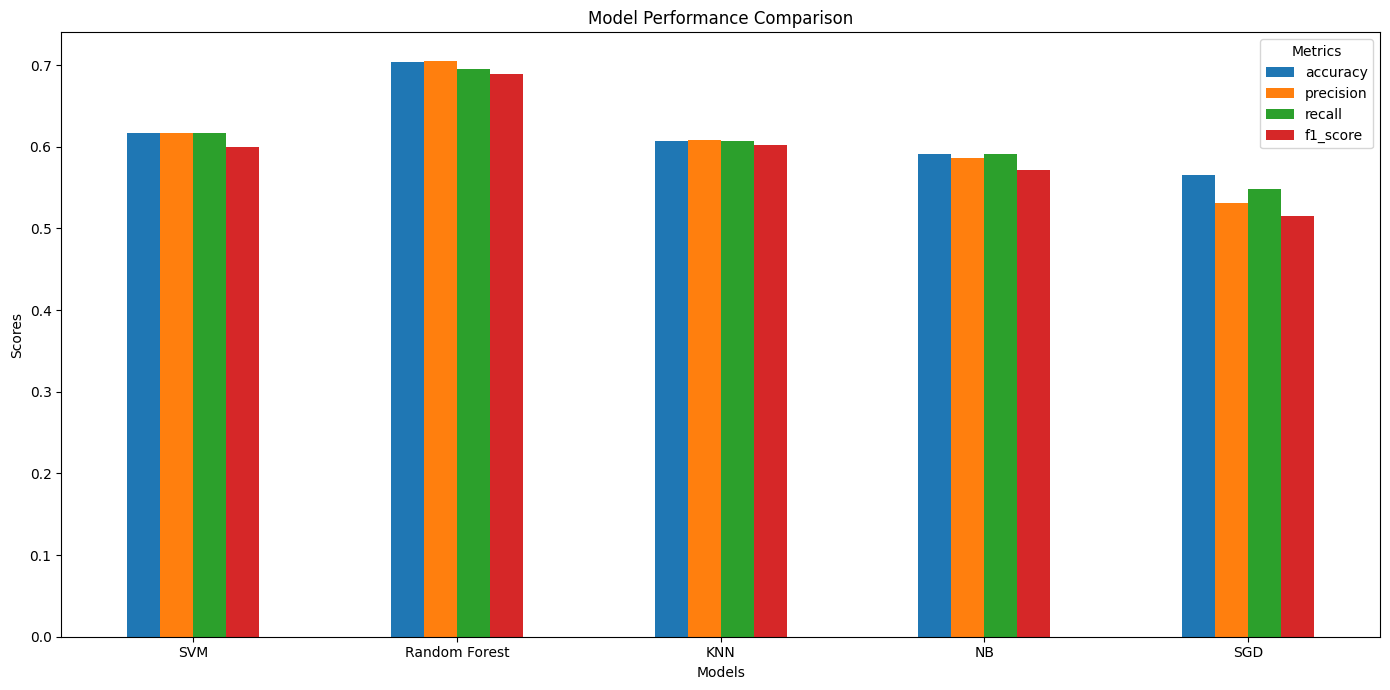

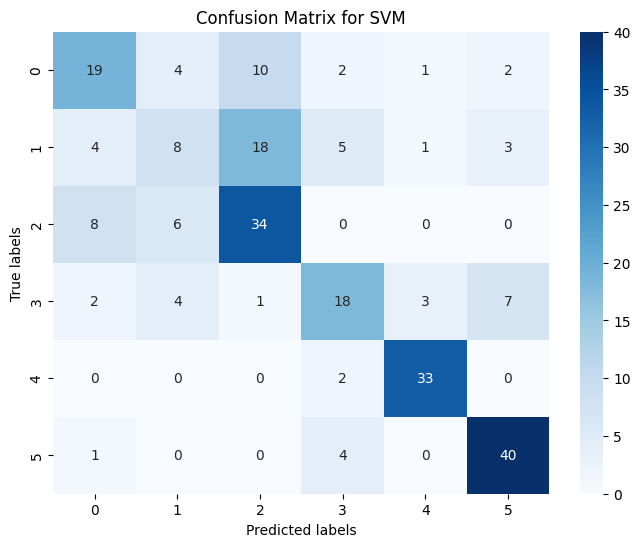

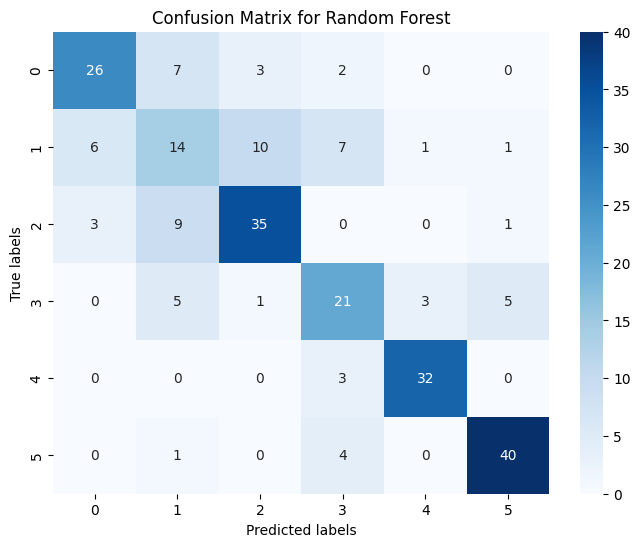

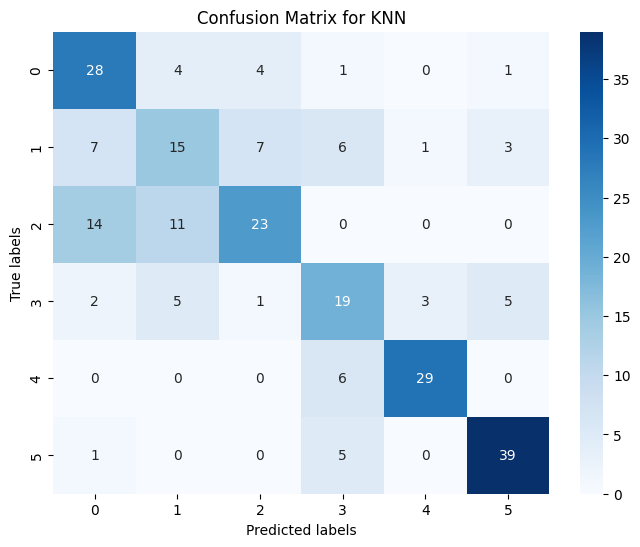

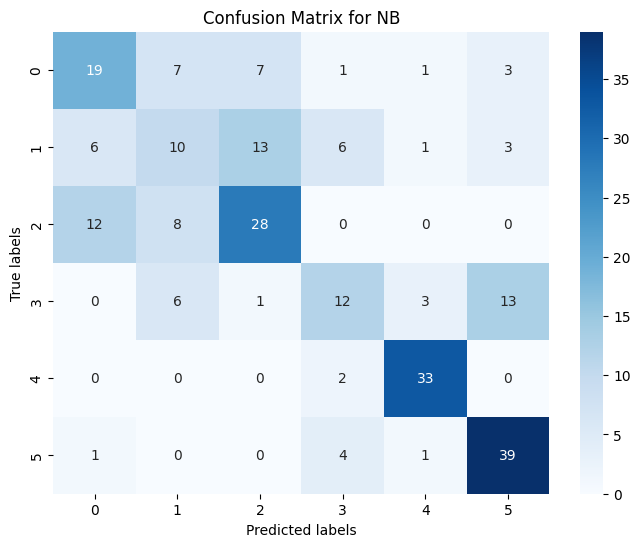

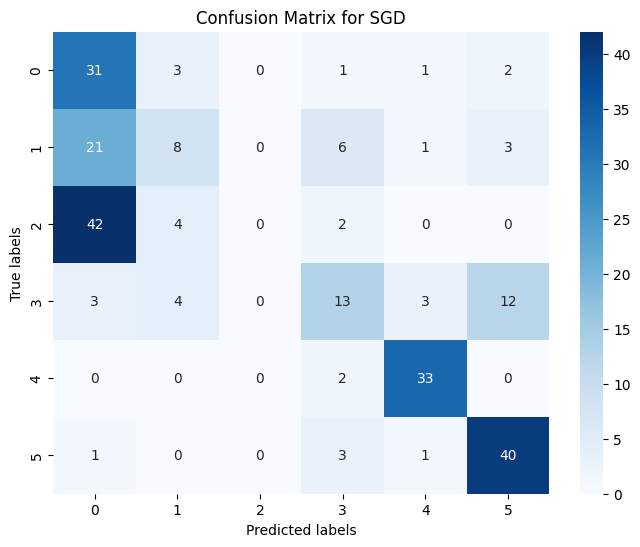

Evaluating: SVM
Model - SVM
Average Expected loss: 0.391
Average bias: 0.367
Average variance: 0.129
----------------------------------------------
Evaluating: Random Forest
Model - Random Forest
Average Expected loss: 0.318
Average bias: 0.292
Average variance: 0.136
----------------------------------------------
Evaluating: KNN
Model - KNN
Average Expected loss: 0.403
Average bias: 0.342
Average variance: 0.216
----------------------------------------------
Evaluating: NB
Model - NB
Average Expected loss: 0.438
Average bias: 0.408
Average variance: 0.148
----------------------------------------------
Evaluating: SGD
Model - SGD
Average Expected loss: 0.460
Average bias: 0.417
Average variance: 0.274
----------------------------------------------


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from mlxtend.evaluate import bias_variance_decomp
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn.pipeline import Pipeline
import numpy as np

# df['text'] = df['Tokens'].apply(lambda x: ' '.join(x))
# Step 2: Convert tokens into numerical features
# SVM Accuracy: 0.7208333333333333
vectorizer = CountVectorizer(tokenizer=lambda x: x, lowercase=False)
X = vectorizer.fit_transform(df['Tokens'])


# vectorizer = CountVectorizer(ngram_range=(1, 2))  # Adjust ngram_range as needed
# X = vectorizer.fit_transform(df['text'])
# y = df['Label'].values
# SVM Accuracy: 0.36666666666666664
# Step 3: Apply LDA transformation
lda = LatentDirichletAllocation(n_components=10)  # Adjust number of topics as needed
X_lda = lda.fit_transform(X)
y = df['Author'].values


# Step 4: Train SVM model
X_train, X_test, y_train, y_test = train_test_split(X_lda, y, test_size=0.2, random_state=42)

#10-fold cross validation:

svm_model = SVC()
svm_model.fit(X_train, y_train)
svm_scores = cross_val_score(svm_model, X_lda, y, cv=10)
print("SVM Accuracy:", np.mean(svm_scores))


rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_scores = cross_val_score(rf_model, X_lda, y, cv=10)
print("Random Forest Accuracy:", np.mean(rf_scores))


knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
knn_scores = cross_val_score(knn_model, X_lda, y, cv=10)
print("KNN Accuracy:", np.mean(knn_scores))

nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
nb_scores = cross_val_score(nb_model,  X_lda, y, cv=10)
print("NB Accuracy:", np.mean(nb_scores))

sgd_model = SGDClassifier()
sgd_model.fit(X_train, y_train)
sgd_scores = cross_val_score(sgd_model,  X_lda, y, cv=10)
print("SGD Accuracy:", np.mean(sgd_scores))

# Initialize the models
svm_model = SVC()
rf_model = RandomForestClassifier()
knn_model = KNeighborsClassifier()
nb_model = MultinomialNB()
sgd_model = SGDClassifier()

# Function to perform cross-validation and calculate average performance metrics
def evaluate_model_with_cv(model, X, y, cv_folds):
    metrics = {
        'accuracy': cross_val_score(model, X, y, cv=cv_folds, scoring='accuracy').mean(),
        'precision': cross_val_score(model, X, y, cv=cv_folds, scoring=make_scorer(precision_score, average='weighted')).mean(),
        'recall': cross_val_score(model, X, y, cv=cv_folds, scoring=make_scorer(recall_score, average='weighted')).mean(),
        'f1_score': cross_val_score(model, X, y, cv=cv_folds, scoring=make_scorer(f1_score, average='weighted')).mean(),
    }
    return metrics

# Dictionary to store the performance of each model
models_performance = {}

# Perform 10-fold cross-validation and store their performance
for name, model in [('SVM', svm_model), ('Random Forest', rf_model), ('KNN', knn_model), ('NB', nb_model), ('SGD',sgd_model)]:
    models_performance[name] = evaluate_model_with_cv(model,  X_lda, y, 10)

# Convert the performance metrics into a DataFrame for display
performance_df = pd.DataFrame(models_performance).T

# Print the average performance metrics from cross-validation
print(performance_df)

import matplotlib.pyplot as plt

performance_df.plot(kind='bar', figsize=(14, 7))

plt.title('Model Performance Comparison')
plt.ylabel('Scores')
plt.xlabel('Models')
plt.legend(title='Metrics')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


# Assuming X_train, y_train, X_test, and y_test are already defined

def plot_confusion_matrix(y_test, y_pred, model_name):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

models = {
    'SVM': svm_model,
    'Random Forest': rf_model,
    'KNN': knn_model,
    'NB' : nb_model,
    'SGD': sgd_model
}

for name, model in models.items():
    # Here, we fit the model and predict in the same step for plotting
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    plot_confusion_matrix(y_test, y_pred, name)

# bias and variance
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

def compare_models_bias_variability(models, X_train, y_train, X_test, y_test):
    for name, model in models.items():
        print(f"Evaluating: {name}")

        # Performing bias-variance decomposition
        avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
            model, X_train, y_train, X_test, y_test, loss='0-1_loss', num_rounds=200, random_seed=42)

        # Printing the results
        print(f"Model - {name}")
        print(f"Average Expected loss: {avg_expected_loss:.3f}")
        print(f'Average bias: {avg_bias:.3f}')
        print(f'Average variance: {avg_var:.3f}')
        print("----------------------------------------------")

# Define your models here
models = {
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier(),
    "KNN": KNeighborsClassifier(),
    "NB" : MultinomialNB(),
    "SGD" : SGDClassifier()
}

# Call the function with encoded labels
compare_models_bias_variability(models, X_train, y_train_encoded, X_test, y_test_encoded)

In [ ]:
df.columns

Index(['Title', 'Author', 'Label', 'Tokens', 'word_count', 'char_count',
       'avg_word_length', 'sentiment', 'subjectivity_score', 'POS_tags',
       'text', 'Text'],
      dtype='object')

# **TF-IDF/ Malini**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, accuracy_score



# Combine tokens back into strings
df['Processed_Text'] = df['Tokens'].apply(lambda x: ' '.join(x))

# Creating the TF-IDF model
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df['Processed_Text'])
y = df['Author']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SVM
svm_model = SVC()

# Random Forest
rf_model = RandomForestClassifier()

# K-Nearest Neighbors
knn_model = KNeighborsClassifier()

nb_model = MultinomialNB()

sgd_model = SGDClassifier()


# Function to perform cross-validation and calculate average performance metrics
def evaluate_model_with_cv(model, X, y, cv_folds):
    metrics = {
        'accuracy': cross_val_score(model, X, y, cv=cv_folds, scoring='accuracy').mean(),
        'precision': cross_val_score(model, X, y, cv=cv_folds, scoring=make_scorer(precision_score, average='weighted')).mean(),
        'recall': cross_val_score(model, X, y, cv=cv_folds, scoring=make_scorer(recall_score, average='weighted')).mean(),
        'f1_score': cross_val_score(model, X, y, cv=cv_folds, scoring=make_scorer(f1_score, average='weighted')).mean(),
    }
    return metrics

# Dictionary to store the performance of each model
models_performance = {}

# Perform 10-fold cross-validation and store their performance
for name, model in [('SVM', svm_model), ('Random Forest', rf_model), ('KNN', knn_model), ('NB', nb_model), ('SGD',sgd_model)]:
    models_performance[name] = evaluate_model_with_cv(model, X, y, 10)

# Convert the performance metrics into a DataFrame for display
performance_df = pd.DataFrame(models_performance).T

# Print the average performance metrics from cross-validation
print(performance_df)

KeyboardInterrupt: 

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Initialize the models
svm_model = SVC()
rf_model = RandomForestClassifier()
knn_model = KNeighborsClassifier()
nb_model = MultinomialNB()
sgd_model = SGDClassifier()

# Modified function to return accuracies for each fold
def evaluate_model_with_cv(model, X, y, cv_folds):
    accuracies = cross_val_score(model, X, y, cv=cv_folds, scoring='accuracy')
    return accuracies

# Assuming X_ngrams and y are defined in your dataset
# Replace these with your actual data
X_ngrams = np.random.rand(100, 5)  # Dummy data
y = np.random.randint(0, 2, 100)   # Dummy data

# Dictionary to store the accuracies for each fold of each model
models_fold_accuracies = {}

# Perform 10-fold cross-validation and store their accuracies for each fold
for name, model in [('SVM', svm_model), ('Random Forest', rf_model), ('KNN', knn_model), ('NB', nb_model), ('SGD',sgd_model)]:
    models_fold_accuracies[name] = evaluate_model_with_cv(model, X_ngrams, y, 10)

# Plotting the accuracies for each fold
bar_width = 0.25
index = np.arange(10)  # 10 folds

plt.figure(figsize=(15, 8))
plt.bar(index, models_fold_accuracies['SVM'], width=bar_width, label='SVM')
plt.bar(index + bar_width, models_fold_accuracies['Random Forest'], width=bar_width, label='Random Forest')
plt.bar(index + 2 * bar_width, models_fold_accuracies['KNN'], width=bar_width, label='KNN')
plt.bar(index + 3 * bar_width, models_fold_accuracies['NB'], width=bar_width, label='NB')
plt.bar(index + 4 * bar_width, models_fold_accuracies['SGD'], width=bar_width, label='SGD')


plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Accuracy Across 10-Fold Cross Validation for SVM, RF,KNN, NB and SGD')
plt.xticks(index + bar_width, range(1, 11))
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# bias and variablity for tf-idf
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from mlxtend.evaluate import bias_variance_decomp

# If y_train and y_test are not numeric, use LabelEncoder to convert them
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

def compare_models_bias_variability(models, X_train, y_train, X_test, y_test):
    for name, model in models.items():
        print(f"Evaluating: {name}")

        # Performing bias-variance decomposition
        avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
            model, X_train, y_train, X_test, y_test, loss='0-1_loss', num_rounds=200, random_seed=42)

        # Printing the results
        print(f"Model - {name}")
        print(f"Average Expected loss: {avg_expected_loss:.3f}")
        print(f'Average bias: {avg_bias:.3f}')
        print(f'Average variance: {avg_var:.3f}')
        print("----------------------------------------------")

# Define your models here
models = {
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier(),
    "KNN": KNeighborsClassifier(),
    "NB" : MultinomialNB(),
    "SGD" : SGDClassifier()
}

# Call the function with encoded labels
compare_models_bias_variability(models, X_train, y_train_encoded, X_test, y_test_encoded)


Evaluating: SVM
Model - SVM
Average Expected loss: 0.036
Average bias: 0.025
Average variance: 0.020
----------------------------------------------
Evaluating: Random Forest
Model - Random Forest
Average Expected loss: 0.066
Average bias: 0.050
Average variance: 0.032
----------------------------------------------
Evaluating: KNN
Model - KNN
Average Expected loss: 0.084
Average bias: 0.050
Average variance: 0.068
----------------------------------------------
Evaluating: NB
Model - NB
Average Expected loss: 0.034
Average bias: 0.017
Average variance: 0.027
----------------------------------------------
Evaluating: SGD
Model - SGD
Average Expected loss: 0.021
Average bias: 0.013
Average variance: 0.014
----------------------------------------------


# **TF/IDF along with bert embeddings**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from transformers import BertTokenizer, BertModel
import torch
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, cross_val_score
from scipy.sparse import hstack
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from mlxtend.evaluate import bias_variance_decomp

df['Processed_Text'] = df['Tokens'].apply(lambda x: ' '.join(x))

# Creating the TF-IDF model
tfidf = TfidfVectorizer()
tfidf_vectors = tfidf.fit_transform(df['Processed_Text'])
y = df['Author']

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# title_tokens = df['Title'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))
# author_tokens = df['Author'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))
word_tokens = df['Tokens'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))

# Padding and Truncation
max_len = max(len(tokens) for tokens in word_tokens)
# title_inputs = torch.tensor([tokens + [0] * (max_len - len(tokens)) for tokens in title_tokens])
# author_inputs = torch.tensor([tokens + [0] * (max_len - len(tokens)) for tokens in author_tokens])
word_inputs = torch.tensor([tokens + [0] * (max_len - len(tokens)) for tokens in word_tokens])

# Model Initialization
model = BertModel.from_pretrained('bert-base-uncased')

# Batch Processing
batch_size = 32
n_samples = len(df)

features = []
authors = []
a = 1
for i in range(0, n_samples, batch_size):
  word_batch = word_inputs[i:i+batch_size]
# Forward Pass
  with torch.no_grad():
      # title_outputs = model(title_inputs)
      # author_outputs = model(author_inputs)
      word_outputs = model(word_batch)
      print('Finished iteration',a)
      a+=1

# Extract Relevant Information (e.g., [CLS] token embeddings)
# title_cls_embeddings = title_outputs.last_hidden_state[:, 0, :]
# author_cls_embeddings = author_outputs.last_hidden_state[:, 0, :]
  word_cls_embeddings = word_outputs.last_hidden_state[:, 0, :]

  word_embeddings_np = np.array([embedding.numpy() for embedding in word_cls_embeddings])

# Combine Features and BERT Embeddings (if needed)
  authors.extend(df['Author'][i:i+batch_size])

# Train SVM Model
  features.extend(word_embeddings_np)


bert_embeddings = pd.DataFrame(features)
print(bert_embeddings,'shape', bert_embeddings.shape)
vectors = pd.DataFrame(tfidf_vectors.toarray())
print(vectors,'vector Shape', vectors.shape)
# Combine TF-IDF vectors and BERT word embeddings
# combined_features = hstack((tfidf_vectors, features))

features = pd.concat([vectors, bert_embeddings], axis=1)


# X = torch.cat(features, dim=0)


# Split Data
X_train, X_test, y_train, y_test = train_test_split(features, df['Author'] , test_size=0.2, random_state=42)

#10-fold cross validation:

svm_model = SVC()
svm_model.fit(X_train, y_train)
svm_scores = cross_val_score(svm_model, features, df['Author'], cv=10)
print("SVM Accuracy:", np.mean(svm_scores))


rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_scores = cross_val_score(rf_model, features, df['Author'], cv=10)
print("Random Forest Accuracy:", np.mean(rf_scores))


knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
knn_scores = cross_val_score(knn_model, features, df['Author'], cv=10)
print("KNN Accuracy:", np.mean(knn_scores))

# nb_model = MultinomialNB()
# nb_model.fit(X_train, y_train)
# nb_scores = cross_val_score(nb_model,  features, df['Author'], cv=10)
# print("NB Accuracy:", np.mean(nb_scores))

sgd_model = SGDClassifier()
sgd_model.fit(X_train, y_train)
sgd_scores = cross_val_score(sgd_model,  features, df['Author'], cv=10)
print("SGD Accuracy:", np.mean(sgd_scores))

# Initialize the models
svm_model = SVC()
rf_model = RandomForestClassifier()
knn_model = KNeighborsClassifier()
# nb_model = MultinomialNB()
sgd_model = SGDClassifier()
# Function to perform cross-validation and calculate average performance metrics
def evaluate_model_with_cv(model, X, y, cv_folds):
    metrics = {
        'accuracy': cross_val_score(model, X, y, cv=cv_folds, scoring='accuracy').mean(),
        'precision': cross_val_score(model, X, y, cv=cv_folds, scoring=make_scorer(precision_score, average='weighted')).mean(),
        'recall': cross_val_score(model, X, y, cv=cv_folds, scoring=make_scorer(recall_score, average='weighted')).mean(),
        'f1_score': cross_val_score(model, X, y, cv=cv_folds, scoring=make_scorer(f1_score, average='weighted')).mean(),
    }
    return metrics

# Dictionary to store the performance of each model
models_performance = {}

# Perform 10-fold cross-validation and store their performance
for name, model in [('SVM', svm_model), ('Random Forest', rf_model), ('KNN', knn_model), ('SGD',sgd_model)]:
    models_performance[name] = evaluate_model_with_cv(model, features, df['Author'], 10)

# Convert the performance metrics into a DataFrame for display
performance_df = pd.DataFrame(models_performance).T

# Print the average performance metrics from cross-validation
print(performance_df)

import matplotlib.pyplot as plt

performance_df.plot(kind='bar', figsize=(14, 7))

plt.title('Model Performance Comparison')
plt.ylabel('Scores')
plt.xlabel('Models')
plt.legend(title='Metrics')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


# Assuming X_train, y_train, X_test, and y_test are already defined

def plot_confusion_matrix(y_test, y_pred, model_name):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

models = {
    'SVM': svm_model,
    'Random Forest': rf_model,
    'KNN': knn_model,
    # 'NB' : nb_model,
    'SGD': sgd_model
}

for name, model in models.items():
    # Here, we fit the model and predict in the same step for plotting
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    plot_confusion_matrix(y_test, y_pred, name)

# bias and variance
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

def compare_models_bias_variability(models, X_train, y_train, X_test, y_test):
    for name, model in models.items():
        print(f"Evaluating: {name}")

        # Performing bias-variance decomposition
        avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
            model, X_train, y_train, X_test, y_test, loss='0-1_loss', num_rounds=200, random_seed=42)

        # Printing the results
        print(f"Model - {name}")
        print(f"Average Expected loss: {avg_expected_loss:.3f}")
        print(f'Average bias: {avg_bias:.3f}')
        print(f'Average variance: {avg_var:.3f}')
        print("----------------------------------------------")

# Define your models here
models = {
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier(),
    "KNN": KNeighborsClassifier(),
    # "NB" : MultinomialNB(),
    "SGD" : SGDClassifier()
}

# Call the function with encoded labels
compare_models_bias_variability(models, X_train, y_train_encoded, X_test, y_test_encoded)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Finished iteration 1
Finished iteration 2
Finished iteration 3
Finished iteration 4
Finished iteration 5
Finished iteration 6
Finished iteration 7
Finished iteration 8
Finished iteration 9
Finished iteration 10
Finished iteration 11
Finished iteration 12
Finished iteration 13
Finished iteration 14
Finished iteration 15
Finished iteration 16
Finished iteration 17
Finished iteration 18
Finished iteration 19
Finished iteration 20
Finished iteration 21
Finished iteration 22
Finished iteration 23
Finished iteration 24
Finished iteration 25
Finished iteration 26
Finished iteration 27
Finished iteration 28
Finished iteration 29
Finished iteration 30
Finished iteration 31
Finished iteration 32
Finished iteration 33
Finished iteration 34
Finished iteration 35
Finished iteration 36
Finished iteration 37
Finished iteration 38
           0         1         2         3         4         5         6    \
0    -0.233015  0.270767  0.207921  0.548013 -0.350229 -0.401740  0.747497   
1    -0.260938  0

KeyboardInterrupt: 

## Massaging the data

# 200 P 20 W

In [ ]:
##Libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import random
from urllib import request
import nltk
import requests
from bs4 import BeautifulSoup
import re
from urllib import request
import nltk
import pandas as pd
import random
nltk.download('punkt')

from nltk.corpus import stopwords


nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

##Fetching the text using the url
def text_gutenberg(url_txt):
    response = requests.get(url_txt)
    raw = response.text

    start_regex = r'\*\*\* START OF (THIS|THE) PROJECT GUTENBERG EBOOK'
    end_regex = r'\*\*\* END OF (THIS|THE) PROJECT GUTENBERG EBOOK'

    start_match = re.search(start_regex, raw)
    end_match = re.search(end_regex, raw)

    if start_match and end_match:
        beginning = start_match.end()
        end_position = end_match.start()
        text = raw[beginning:end_position]
        return text
    else:
        print(f"Start or end pattern not found in {url_txt}")
        return ""

#finding the text's title and author
def get_book_info(url_text):
    try:
        response = requests.get(url_text)
        soup = BeautifulSoup(response.text, 'html.parser')

        # Locating the title and author in the content
        content = soup.get_text()
        title_match = re.search(r'Title:\s*([^\n\r]+)', content)
        author_match = re.search(r'Author:\s*([^\n\r]+)', content)

        title = title_match.group(1).strip() if title_match else "Title not found"
        author = author_match.group(1).strip() if author_match else "Author not found"

        return title, author
    except Exception as e:
        return f"Error: {e}"

##Getting the tokens out of the text
def clean_tokens(token_list):
    cleaned = [re.sub('[^a-zA-Z]', ' ', token) for token in token_list if token.lower() not in stop_words]
    cleaned = [token.lower().strip() for token in cleaned if token.strip()]
    return cleaned


## Set a seed for reproducibility
random.seed(42)

#Helper function to make sure functions don't overlap
def get_non_overlapping_start_index(used_indices, record_length, total_length, max_attempts=1000):
    attempt = 0
    while attempt < max_attempts:
        start_index = random.randint(0, total_length - record_length)
        if all(start_index not in range(index, index + record_length) for index in used_indices):
            return start_index
        attempt += 1
    raise ValueError("Unable to find a non-overlapping start index. Consider reducing sample size or record length.")

##Creating the samples -------------------------------------------------------------------------------------------------------------------------
def create_samples(url_txt, label, n_samples=200, record_length=20):
    text = text_gutenberg(url_txt)
    title, author = get_book_info(url_txt)

    words = text.split()
    total_length = len(words)
    used_indices = set()

    samples = []
    for _ in range(n_samples):
        start_index = get_non_overlapping_start_index(used_indices, record_length, total_length)
        used_indices.update(range(start_index, start_index + record_length))

        sample_words = words[start_index:start_index + record_length]
        sample_text = ' '.join(sample_words)

        tokens = nltk.word_tokenize(sample_text)
        cleaned_tokens = clean_tokens(tokens)

        samples.append({'Title': title, 'Author': author, 'Label': label, 'Tokens': cleaned_tokens})

    return samples

##Creating the dataframe
def create_dataframe(book_urls):
    all_samples = []

    for label, url in enumerate(book_urls, start=0):
        book_label = chr(97 + label)  # Generate labels a, b, c, ...
        book_samples = create_samples(url, book_label)
        all_samples.extend(book_samples)

    df = pd.DataFrame(all_samples)
    return df

#Using 6 books of the fantasy genra
book_urls = ["https://www.gutenberg.org/cache/epub/68061/pg68061-images.html",
             "https://www.gutenberg.org/cache/epub/55/pg55-images.html",
             "https://www.gutenberg.org/cache/epub/7477/pg7477-images.html",
             "https://www.gutenberg.org/cache/epub/34219/pg34219-images.html",
             "https://www.gutenberg.org/cache/epub/10662/pg10662-images.html",
             "https://www.gutenberg.org/cache/epub/12753/pg12753-images.html"]
df = create_dataframe(book_urls)


df.head


import pandas as pd
import re
from nltk.corpus import stopwords
nltk.download('wordnet')

##stemming removes suffixes of the word
def stemming(token_list):
  ps = nltk.stem.porter.PorterStemmer()
  stem_txt = [ps.stem(word) for word in token_list]
  return stem_txt

## Lemmatisation (convert the word into root word)
def lemmatisation(token_list):
  lem = nltk.stem.wordnet.WordNetLemmatizer()
  lem_txt = [lem.lemmatize(word) for word in token_list]
  return lem_txt


df['Tokens'] = df['Tokens'].apply(stemming)
df['Tokens'] = df['Tokens'].apply(lemmatisation)
df.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Title,Author,Label,Tokens
0,Lud-in-the-Mist,Hope Mirrlees,a,"[hazel, time, protest, gave, smack, kiss, lip,..."
1,Lud-in-the-Mist,Hope Mirrlees,a,"[glass, said, briskli, leer, let, s, go, busi,..."
2,Lud-in-the-Mist,Hope Mirrlees,a,"[court, jester, commit, suicid, free, began, w..."
3,Lud-in-the-Mist,Hope Mirrlees,a,"[div, class, poetri, div, class, stanza, div, ..."
4,Lud-in-the-Mist,Hope Mirrlees,a,"[would, comfort, talk, man, boat, himself if]"


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
# Convert list of tokens to strings
df['text'] = df['Tokens'].apply(lambda x: ' '.join(x))

# Create n-gram features
vectorizer = CountVectorizer(ngram_range=(1, 2))
X_ngrams = vectorizer.fit_transform(df['text'])
y = df['Author'].values


X_train, X_test, y_train, y_test = train_test_split(X_ngrams, y, test_size=0.2, random_state=42)


from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
import numpy as np
import pandas as pd


# Initialize the models
# svm_model = SVC()
# rf_model = RandomForestClassifier()
# knn_model = KNeighborsClassifier()
nb_model = MultinomialNB()
# sgd_model = SGDClassifier()

# Function to perform cross-validation and calculate average performance metrics
def evaluate_model_with_cv(model, X, y, cv_folds):
    metrics = {
        'accuracy': cross_val_score(model, X, y, cv=cv_folds, scoring='accuracy').mean(),
        'precision': cross_val_score(model, X, y, cv=cv_folds, scoring=make_scorer(precision_score, average='weighted')).mean(),
        'recall': cross_val_score(model, X, y, cv=cv_folds, scoring=make_scorer(recall_score, average='weighted')).mean(),
        'f1_score': cross_val_score(model, X, y, cv=cv_folds, scoring=make_scorer(f1_score, average='weighted')).mean(),
    }
    return metrics

# Dictionary to store the performance of each model
models_performance = {}

# Perform 10-fold cross-validation and store their performance
for name, model in [('NB', nb_model)]:
    models_performance[name] = evaluate_model_with_cv(model, X_ngrams, y, 10)

# Convert the performance metrics into a DataFrame for display
performance_df = pd.DataFrame(models_performance).T

# Print the average performance metrics from cross-validation
print('200 Partitions and 20 Words')
print(performance_df)


200 Partitions and 20 Words
    accuracy  f1_score  precision    recall
NB  0.766667  0.763267   0.783222  0.766667


## 200 Partitions and 19 words

In [ ]:
##Libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import random
from urllib import request
import nltk
import requests
from bs4 import BeautifulSoup
import re
from urllib import request
import nltk
import pandas as pd
import random
nltk.download('punkt')

from nltk.corpus import stopwords


nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

##Fetching the text using the url
def text_gutenberg(url_txt):
    response = requests.get(url_txt)
    raw = response.text

    start_regex = r'\*\*\* START OF (THIS|THE) PROJECT GUTENBERG EBOOK'
    end_regex = r'\*\*\* END OF (THIS|THE) PROJECT GUTENBERG EBOOK'

    start_match = re.search(start_regex, raw)
    end_match = re.search(end_regex, raw)

    if start_match and end_match:
        beginning = start_match.end()
        end_position = end_match.start()
        text = raw[beginning:end_position]
        return text
    else:
        print(f"Start or end pattern not found in {url_txt}")
        return ""

#finding the text's title and author
def get_book_info(url_text):
    try:
        response = requests.get(url_text)
        soup = BeautifulSoup(response.text, 'html.parser')

        # Locating the title and author in the content
        content = soup.get_text()
        title_match = re.search(r'Title:\s*([^\n\r]+)', content)
        author_match = re.search(r'Author:\s*([^\n\r]+)', content)

        title = title_match.group(1).strip() if title_match else "Title not found"
        author = author_match.group(1).strip() if author_match else "Author not found"

        return title, author
    except Exception as e:
        return f"Error: {e}"

##Getting the tokens out of the text
def clean_tokens(token_list):
    cleaned = [re.sub('[^a-zA-Z]', ' ', token) for token in token_list if token.lower() not in stop_words]
    cleaned = [token.lower().strip() for token in cleaned if token.strip()]
    return cleaned


## Set a seed for reproducibility
random.seed(42)

#Helper function to make sure functions don't overlap
def get_non_overlapping_start_index(used_indices, record_length, total_length, max_attempts=1000):
    attempt = 0
    while attempt < max_attempts:
        start_index = random.randint(0, total_length - record_length)
        if all(start_index not in range(index, index + record_length) for index in used_indices):
            return start_index
        attempt += 1
    raise ValueError("Unable to find a non-overlapping start index. Consider reducing sample size or record length.")

##Creating the samples -------------------------------------------------------------------------------------------------------------------------
def create_samples(url_txt, label, n_samples=200, record_length=19):
    text = text_gutenberg(url_txt)
    title, author = get_book_info(url_txt)

    words = text.split()
    total_length = len(words)
    used_indices = set()

    samples = []
    for _ in range(n_samples):
        start_index = get_non_overlapping_start_index(used_indices, record_length, total_length)
        used_indices.update(range(start_index, start_index + record_length))

        sample_words = words[start_index:start_index + record_length]
        sample_text = ' '.join(sample_words)

        tokens = nltk.word_tokenize(sample_text)
        cleaned_tokens = clean_tokens(tokens)

        samples.append({'Title': title, 'Author': author, 'Label': label, 'Tokens': cleaned_tokens})

    return samples

##Creating the dataframe
def create_dataframe(book_urls):
    all_samples = []

    for label, url in enumerate(book_urls, start=0):
        book_label = chr(97 + label)  # Generate labels a, b, c, ...
        book_samples = create_samples(url, book_label)
        all_samples.extend(book_samples)

    df = pd.DataFrame(all_samples)
    return df

#Using 6 books of the fantasy genra
book_urls = ["https://www.gutenberg.org/cache/epub/68061/pg68061-images.html",
             "https://www.gutenberg.org/cache/epub/55/pg55-images.html",
             "https://www.gutenberg.org/cache/epub/7477/pg7477-images.html",
             "https://www.gutenberg.org/cache/epub/34219/pg34219-images.html",
             "https://www.gutenberg.org/cache/epub/10662/pg10662-images.html",
             "https://www.gutenberg.org/cache/epub/12753/pg12753-images.html"]
df = create_dataframe(book_urls)


df.head


import pandas as pd
import re
from nltk.corpus import stopwords
nltk.download('wordnet')

##stemming removes suffixes of the word
def stemming(token_list):
  ps = nltk.stem.porter.PorterStemmer()
  stem_txt = [ps.stem(word) for word in token_list]
  return stem_txt

## Lemmatisation (convert the word into root word)
def lemmatisation(token_list):
  lem = nltk.stem.wordnet.WordNetLemmatizer()
  lem_txt = [lem.lemmatize(word) for word in token_list]
  return lem_txt


df['Tokens'] = df['Tokens'].apply(stemming)
df['Tokens'] = df['Tokens'].apply(lemmatisation)
df.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Title,Author,Label,Tokens
0,Lud-in-the-Mist,Hope Mirrlees,a,"[hazel, time, protest, gave, smack, kiss, lip,..."
1,Lud-in-the-Mist,Hope Mirrlees,a,"[glass, said, briskli, leer, let, s, go, busi,..."
2,Lud-in-the-Mist,Hope Mirrlees,a,"[court, jester, commit, suicid, free, began, w..."
3,Lud-in-the-Mist,Hope Mirrlees,a,"[div, class, poetri, div, class, stanza, div, ..."
4,Lud-in-the-Mist,Hope Mirrlees,a,"[would, comfort, talk, man, boat, himself if]"


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
# Convert list of tokens to strings
df['text'] = df['Tokens'].apply(lambda x: ' '.join(x))

# Create n-gram features
vectorizer = CountVectorizer(ngram_range=(1, 2))
X_ngrams = vectorizer.fit_transform(df['text'])
y = df['Author'].values


X_train, X_test, y_train, y_test = train_test_split(X_ngrams, y, test_size=0.2, random_state=42)


from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
import numpy as np
import pandas as pd


# Initialize the models
# svm_model = SVC()
# rf_model = RandomForestClassifier()
# knn_model = KNeighborsClassifier()
nb_model = MultinomialNB()
# sgd_model = SGDClassifier()

# Function to perform cross-validation and calculate average performance metrics
def evaluate_model_with_cv(model, X, y, cv_folds):
    metrics = {
        'accuracy': cross_val_score(model, X, y, cv=cv_folds, scoring='accuracy').mean(),
        'precision': cross_val_score(model, X, y, cv=cv_folds, scoring=make_scorer(precision_score, average='weighted')).mean(),
        'recall': cross_val_score(model, X, y, cv=cv_folds, scoring=make_scorer(recall_score, average='weighted')).mean(),
        'f1_score': cross_val_score(model, X, y, cv=cv_folds, scoring=make_scorer(f1_score, average='weighted')).mean(),
    }
    return metrics

# Dictionary to store the performance of each model
models_performance = {}

# Perform 10-fold cross-validation and store their performance
for name, model in [('NB', nb_model)]:
    models_performance[name] = evaluate_model_with_cv(model, X_ngrams, y, 10)

# Convert the performance metrics into a DataFrame for display
performance_df = pd.DataFrame(models_performance).T

# Print the average performance metrics from cross-validation
print('200 Partitions and 19 Words')
print(performance_df)


200 Partitions and 19 Words
    accuracy  f1_score  precision    recall
NB  0.750833  0.746587   0.767728  0.750833


# 200 Partitions and 10 Words

In [ ]:
##Libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import random
from urllib import request
import nltk
import requests
from bs4 import BeautifulSoup
import re
from urllib import request
import nltk
import pandas as pd
import random
nltk.download('punkt')

from nltk.corpus import stopwords


nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

##Fetching the text using the url
def text_gutenberg(url_txt):
    response = requests.get(url_txt)
    raw = response.text

    start_regex = r'\*\*\* START OF (THIS|THE) PROJECT GUTENBERG EBOOK'
    end_regex = r'\*\*\* END OF (THIS|THE) PROJECT GUTENBERG EBOOK'

    start_match = re.search(start_regex, raw)
    end_match = re.search(end_regex, raw)

    if start_match and end_match:
        beginning = start_match.end()
        end_position = end_match.start()
        text = raw[beginning:end_position]
        return text
    else:
        print(f"Start or end pattern not found in {url_txt}")
        return ""

#finding the text's title and author
def get_book_info(url_text):
    try:
        response = requests.get(url_text)
        soup = BeautifulSoup(response.text, 'html.parser')

        # Locating the title and author in the content
        content = soup.get_text()
        title_match = re.search(r'Title:\s*([^\n\r]+)', content)
        author_match = re.search(r'Author:\s*([^\n\r]+)', content)

        title = title_match.group(1).strip() if title_match else "Title not found"
        author = author_match.group(1).strip() if author_match else "Author not found"

        return title, author
    except Exception as e:
        return f"Error: {e}"

##Getting the tokens out of the text
def clean_tokens(token_list):
    cleaned = [re.sub('[^a-zA-Z]', ' ', token) for token in token_list if token.lower() not in stop_words]
    cleaned = [token.lower().strip() for token in cleaned if token.strip()]
    return cleaned


## Set a seed for reproducibility
random.seed(42)

#Helper function to make sure functions don't overlap
def get_non_overlapping_start_index(used_indices, record_length, total_length, max_attempts=1000):
    attempt = 0
    while attempt < max_attempts:
        start_index = random.randint(0, total_length - record_length)
        if all(start_index not in range(index, index + record_length) for index in used_indices):
            return start_index
        attempt += 1
    raise ValueError("Unable to find a non-overlapping start index. Consider reducing sample size or record length.")

##Creating the samples -------------------------------------------------------------------------------------------------------------------------
def create_samples(url_txt, label, n_samples=200, record_length=10):
    text = text_gutenberg(url_txt)
    title, author = get_book_info(url_txt)

    words = text.split()
    total_length = len(words)
    used_indices = set()

    samples = []
    for _ in range(n_samples):
        start_index = get_non_overlapping_start_index(used_indices, record_length, total_length)
        used_indices.update(range(start_index, start_index + record_length))

        sample_words = words[start_index:start_index + record_length]
        sample_text = ' '.join(sample_words)

        tokens = nltk.word_tokenize(sample_text)
        cleaned_tokens = clean_tokens(tokens)

        samples.append({'Title': title, 'Author': author, 'Label': label, 'Tokens': cleaned_tokens})

    return samples

##Creating the dataframe
def create_dataframe(book_urls):
    all_samples = []

    for label, url in enumerate(book_urls, start=0):
        book_label = chr(97 + label)  # Generate labels a, b, c, ...
        book_samples = create_samples(url, book_label)
        all_samples.extend(book_samples)

    df = pd.DataFrame(all_samples)
    return df

#Using 6 books of the fantasy genra
book_urls = ["https://www.gutenberg.org/cache/epub/68061/pg68061-images.html",
             "https://www.gutenberg.org/cache/epub/55/pg55-images.html",
             "https://www.gutenberg.org/cache/epub/7477/pg7477-images.html",
             "https://www.gutenberg.org/cache/epub/34219/pg34219-images.html",
             "https://www.gutenberg.org/cache/epub/10662/pg10662-images.html",
             "https://www.gutenberg.org/cache/epub/12753/pg12753-images.html"]
df = create_dataframe(book_urls)


df.head


import pandas as pd
import re
from nltk.corpus import stopwords
nltk.download('wordnet')

##stemming removes suffixes of the word
def stemming(token_list):
  ps = nltk.stem.porter.PorterStemmer()
  stem_txt = [ps.stem(word) for word in token_list]
  return stem_txt

## Lemmatisation (convert the word into root word)
def lemmatisation(token_list):
  lem = nltk.stem.wordnet.WordNetLemmatizer()
  lem_txt = [lem.lemmatize(word) for word in token_list]
  return lem_txt


df['Tokens'] = df['Tokens'].apply(stemming)
df['Tokens'] = df['Tokens'].apply(lemmatisation)
df.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Title,Author,Label,Tokens
0,Lud-in-the-Mist,Hope Mirrlees,a,"[hazel, time, protest, gave]"
1,Lud-in-the-Mist,Hope Mirrlees,a,"[glass, said, briskli, leer, let, s]"
2,Lud-in-the-Mist,Hope Mirrlees,a,"[court, jester, commit, suicid, free]"
3,Lud-in-the-Mist,Hope Mirrlees,a,"[div, class, poetri, div, class, stanza, div, ..."
4,Lud-in-the-Mist,Hope Mirrlees,a,"[would, comfort, talk, man]"


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
# Convert list of tokens to strings
df['text'] = df['Tokens'].apply(lambda x: ' '.join(x))

# Create n-gram features
vectorizer = CountVectorizer(ngram_range=(1, 2))
X_ngrams = vectorizer.fit_transform(df['text'])
y = df['Author'].values


X_train, X_test, y_train, y_test = train_test_split(X_ngrams, y, test_size=0.2, random_state=42)


from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
import numpy as np
import pandas as pd


# Initialize the models
# svm_model = SVC()
# rf_model = RandomForestClassifier()
# knn_model = KNeighborsClassifier()
nb_model = MultinomialNB()
# sgd_model = SGDClassifier()

# Function to perform cross-validation and calculate average performance metrics
def evaluate_model_with_cv(model, X, y, cv_folds):
    metrics = {
        'accuracy': cross_val_score(model, X, y, cv=cv_folds, scoring='accuracy').mean(),
        'precision': cross_val_score(model, X, y, cv=cv_folds, scoring=make_scorer(precision_score, average='weighted')).mean(),
        'recall': cross_val_score(model, X, y, cv=cv_folds, scoring=make_scorer(recall_score, average='weighted')).mean(),
        'f1_score': cross_val_score(model, X, y, cv=cv_folds, scoring=make_scorer(f1_score, average='weighted')).mean(),
    }
    return metrics

# Dictionary to store the performance of each model
models_performance = {}

# Perform 10-fold cross-validation and store their performance
for name, model in [('NB', nb_model)]:
    models_performance[name] = evaluate_model_with_cv(model, X_ngrams, y, 10)

# Convert the performance metrics into a DataFrame for display
performance_df = pd.DataFrame(models_performance).T

# Print the average performance metrics from cross-validation
print('200 Partitions and 10 Words')
print(performance_df)


200 Partitions and 10 Words
    accuracy  f1_score  precision    recall
NB  0.541667   0.53273   0.546647  0.541667


# 100 Partitions and 50 Words

In [ ]:
##Libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import random
from urllib import request
import nltk
import requests
from bs4 import BeautifulSoup
import re
from urllib import request
import nltk
import pandas as pd
import random
nltk.download('punkt')

from nltk.corpus import stopwords


nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

##Fetching the text using the url
def text_gutenberg(url_txt):
    response = requests.get(url_txt)
    raw = response.text

    start_regex = r'\*\*\* START OF (THIS|THE) PROJECT GUTENBERG EBOOK'
    end_regex = r'\*\*\* END OF (THIS|THE) PROJECT GUTENBERG EBOOK'

    start_match = re.search(start_regex, raw)
    end_match = re.search(end_regex, raw)

    if start_match and end_match:
        beginning = start_match.end()
        end_position = end_match.start()
        text = raw[beginning:end_position]
        return text
    else:
        print(f"Start or end pattern not found in {url_txt}")
        return ""

#finding the text's title and author
def get_book_info(url_text):
    try:
        response = requests.get(url_text)
        soup = BeautifulSoup(response.text, 'html.parser')

        # Locating the title and author in the content
        content = soup.get_text()
        title_match = re.search(r'Title:\s*([^\n\r]+)', content)
        author_match = re.search(r'Author:\s*([^\n\r]+)', content)

        title = title_match.group(1).strip() if title_match else "Title not found"
        author = author_match.group(1).strip() if author_match else "Author not found"

        return title, author
    except Exception as e:
        return f"Error: {e}"

##Getting the tokens out of the text
def clean_tokens(token_list):
    cleaned = [re.sub('[^a-zA-Z]', ' ', token) for token in token_list if token.lower() not in stop_words]
    cleaned = [token.lower().strip() for token in cleaned if token.strip()]
    return cleaned


## Set a seed for reproducibility
random.seed(42)

#Helper function to make sure functions don't overlap
def get_non_overlapping_start_index(used_indices, record_length, total_length, max_attempts=1000):
    attempt = 0
    while attempt < max_attempts:
        start_index = random.randint(0, total_length - record_length)
        if all(start_index not in range(index, index + record_length) for index in used_indices):
            return start_index
        attempt += 1
    raise ValueError("Unable to find a non-overlapping start index. Consider reducing sample size or record length.")

##Creating the samples -------------------------------------------------------------------------------------------------------------------------
def create_samples(url_txt, label, n_samples=100, record_length=50):
    text = text_gutenberg(url_txt)
    title, author = get_book_info(url_txt)

    words = text.split()
    total_length = len(words)
    used_indices = set()

    samples = []
    for _ in range(n_samples):
        start_index = get_non_overlapping_start_index(used_indices, record_length, total_length)
        used_indices.update(range(start_index, start_index + record_length))

        sample_words = words[start_index:start_index + record_length]
        sample_text = ' '.join(sample_words)

        tokens = nltk.word_tokenize(sample_text)
        cleaned_tokens = clean_tokens(tokens)

        samples.append({'Title': title, 'Author': author, 'Label': label, 'Tokens': cleaned_tokens})

    return samples

##Creating the dataframe
def create_dataframe(book_urls):
    all_samples = []

    for label, url in enumerate(book_urls, start=0):
        book_label = chr(97 + label)  # Generate labels a, b, c, ...
        book_samples = create_samples(url, book_label)
        all_samples.extend(book_samples)

    df = pd.DataFrame(all_samples)
    return df

#Using 6 books of the fantasy genra
book_urls = ["https://www.gutenberg.org/cache/epub/68061/pg68061-images.html",
             "https://www.gutenberg.org/cache/epub/55/pg55-images.html",
             "https://www.gutenberg.org/cache/epub/7477/pg7477-images.html",
             "https://www.gutenberg.org/cache/epub/34219/pg34219-images.html",
             "https://www.gutenberg.org/cache/epub/10662/pg10662-images.html",
             "https://www.gutenberg.org/cache/epub/12753/pg12753-images.html"]
df = create_dataframe(book_urls)


df.head


import pandas as pd
import re
from nltk.corpus import stopwords
nltk.download('wordnet')

##stemming removes suffixes of the word
def stemming(token_list):
  ps = nltk.stem.porter.PorterStemmer()
  stem_txt = [ps.stem(word) for word in token_list]
  return stem_txt

## Lemmatisation (convert the word into root word)
def lemmatisation(token_list):
  lem = nltk.stem.wordnet.WordNetLemmatizer()
  lem_txt = [lem.lemmatize(word) for word in token_list]
  return lem_txt


df['Tokens'] = df['Tokens'].apply(stemming)
df['Tokens'] = df['Tokens'].apply(lemmatisation)
df.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Title,Author,Label,Tokens
0,Lud-in-the-Mist,Hope Mirrlees,a,"[hazel, time, protest, gave, smack, kiss, lip,..."
1,Lud-in-the-Mist,Hope Mirrlees,a,"[glass, said, briskli, leer, let, s, go, busi,..."
2,Lud-in-the-Mist,Hope Mirrlees,a,"[court, jester, commit, suicid, free, began, w..."
3,Lud-in-the-Mist,Hope Mirrlees,a,"[div, class, poetri, div, class, stanza, div, ..."
4,Lud-in-the-Mist,Hope Mirrlees,a,"[would, comfort, talk, man, boat, himself if, ..."


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
# Convert list of tokens to strings
df['text'] = df['Tokens'].apply(lambda x: ' '.join(x))

# Create n-gram features
vectorizer = CountVectorizer(ngram_range=(1, 2))
X_ngrams = vectorizer.fit_transform(df['text'])
y = df['Author'].values


X_train, X_test, y_train, y_test = train_test_split(X_ngrams, y, test_size=0.2, random_state=42)


from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
import numpy as np
import pandas as pd


# Initialize the models
# svm_model = SVC()
# rf_model = RandomForestClassifier()
# knn_model = KNeighborsClassifier()
nb_model = MultinomialNB()
# sgd_model = SGDClassifier()

# Function to perform cross-validation and calculate average performance metrics
def evaluate_model_with_cv(model, X, y, cv_folds):
    metrics = {
        'accuracy': cross_val_score(model, X, y, cv=cv_folds, scoring='accuracy').mean(),
        'precision': cross_val_score(model, X, y, cv=cv_folds, scoring=make_scorer(precision_score, average='weighted')).mean(),
        'recall': cross_val_score(model, X, y, cv=cv_folds, scoring=make_scorer(recall_score, average='weighted')).mean(),
        'f1_score': cross_val_score(model, X, y, cv=cv_folds, scoring=make_scorer(f1_score, average='weighted')).mean(),
    }
    return metrics

# Dictionary to store the performance of each model
models_performance = {}

# Perform 10-fold cross-validation and store their performance
for name, model in [('NB', nb_model)]:
    models_performance[name] = evaluate_model_with_cv(model, X_ngrams, y, 10)

# Convert the performance metrics into a DataFrame for display
performance_df = pd.DataFrame(models_performance).T

# Print the average performance metrics from cross-validation
print('100 Partitions and 50 Words')
print(performance_df)


100 Partitions and 50 Words
    accuracy  f1_score  precision    recall
NB  0.911667  0.909922   0.919357  0.911667


# 100 Partitions and 40 Words

In [ ]:
##Libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import random
from urllib import request
import nltk
import requests
from bs4 import BeautifulSoup
import re
from urllib import request
import nltk
import pandas as pd
import random
nltk.download('punkt')

from nltk.corpus import stopwords


nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

##Fetching the text using the url
def text_gutenberg(url_txt):
    response = requests.get(url_txt)
    raw = response.text

    start_regex = r'\*\*\* START OF (THIS|THE) PROJECT GUTENBERG EBOOK'
    end_regex = r'\*\*\* END OF (THIS|THE) PROJECT GUTENBERG EBOOK'

    start_match = re.search(start_regex, raw)
    end_match = re.search(end_regex, raw)

    if start_match and end_match:
        beginning = start_match.end()
        end_position = end_match.start()
        text = raw[beginning:end_position]
        return text
    else:
        print(f"Start or end pattern not found in {url_txt}")
        return ""

#finding the text's title and author
def get_book_info(url_text):
    try:
        response = requests.get(url_text)
        soup = BeautifulSoup(response.text, 'html.parser')

        # Locating the title and author in the content
        content = soup.get_text()
        title_match = re.search(r'Title:\s*([^\n\r]+)', content)
        author_match = re.search(r'Author:\s*([^\n\r]+)', content)

        title = title_match.group(1).strip() if title_match else "Title not found"
        author = author_match.group(1).strip() if author_match else "Author not found"

        return title, author
    except Exception as e:
        return f"Error: {e}"

##Getting the tokens out of the text
def clean_tokens(token_list):
    cleaned = [re.sub('[^a-zA-Z]', ' ', token) for token in token_list if token.lower() not in stop_words]
    cleaned = [token.lower().strip() for token in cleaned if token.strip()]
    return cleaned


## Set a seed for reproducibility
random.seed(42)

#Helper function to make sure functions don't overlap
def get_non_overlapping_start_index(used_indices, record_length, total_length, max_attempts=1000):
    attempt = 0
    while attempt < max_attempts:
        start_index = random.randint(0, total_length - record_length)
        if all(start_index not in range(index, index + record_length) for index in used_indices):
            return start_index
        attempt += 1
    raise ValueError("Unable to find a non-overlapping start index. Consider reducing sample size or record length.")

##Creating the samples -------------------------------------------------------------------------------------------------------------------------
def create_samples(url_txt, label, n_samples=100, record_length=40):
    text = text_gutenberg(url_txt)
    title, author = get_book_info(url_txt)

    words = text.split()
    total_length = len(words)
    used_indices = set()

    samples = []
    for _ in range(n_samples):
        start_index = get_non_overlapping_start_index(used_indices, record_length, total_length)
        used_indices.update(range(start_index, start_index + record_length))

        sample_words = words[start_index:start_index + record_length]
        sample_text = ' '.join(sample_words)

        tokens = nltk.word_tokenize(sample_text)
        cleaned_tokens = clean_tokens(tokens)

        samples.append({'Title': title, 'Author': author, 'Label': label, 'Tokens': cleaned_tokens})

    return samples

##Creating the dataframe
def create_dataframe(book_urls):
    all_samples = []

    for label, url in enumerate(book_urls, start=0):
        book_label = chr(97 + label)  # Generate labels a, b, c, ...
        book_samples = create_samples(url, book_label)
        all_samples.extend(book_samples)

    df = pd.DataFrame(all_samples)
    return df

#Using 6 books of the fantasy genra
book_urls = ["https://www.gutenberg.org/cache/epub/68061/pg68061-images.html",
             "https://www.gutenberg.org/cache/epub/55/pg55-images.html",
             "https://www.gutenberg.org/cache/epub/7477/pg7477-images.html",
             "https://www.gutenberg.org/cache/epub/34219/pg34219-images.html",
             "https://www.gutenberg.org/cache/epub/10662/pg10662-images.html",
             "https://www.gutenberg.org/cache/epub/12753/pg12753-images.html"]
df = create_dataframe(book_urls)


df.head


import pandas as pd
import re
from nltk.corpus import stopwords
nltk.download('wordnet')

##stemming removes suffixes of the word
def stemming(token_list):
  ps = nltk.stem.porter.PorterStemmer()
  stem_txt = [ps.stem(word) for word in token_list]
  return stem_txt

## Lemmatisation (convert the word into root word)
def lemmatisation(token_list):
  lem = nltk.stem.wordnet.WordNetLemmatizer()
  lem_txt = [lem.lemmatize(word) for word in token_list]
  return lem_txt


df['Tokens'] = df['Tokens'].apply(stemming)
df['Tokens'] = df['Tokens'].apply(lemmatisation)
df.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Title,Author,Label,Tokens
0,Lud-in-the-Mist,Hope Mirrlees,a,"[hazel, time, protest, gave, smack, kiss, lip,..."
1,Lud-in-the-Mist,Hope Mirrlees,a,"[glass, said, briskli, leer, let, s, go, busi,..."
2,Lud-in-the-Mist,Hope Mirrlees,a,"[court, jester, commit, suicid, free, began, w..."
3,Lud-in-the-Mist,Hope Mirrlees,a,"[div, class, poetri, div, class, stanza, div, ..."
4,Lud-in-the-Mist,Hope Mirrlees,a,"[would, comfort, talk, man, boat, himself if, ..."


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
# Convert list of tokens to strings
df['text'] = df['Tokens'].apply(lambda x: ' '.join(x))

# Create n-gram features
vectorizer = CountVectorizer(ngram_range=(1, 2))
X_ngrams = vectorizer.fit_transform(df['text'])
y = df['Author'].values


X_train, X_test, y_train, y_test = train_test_split(X_ngrams, y, test_size=0.2, random_state=42)


from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
import numpy as np
import pandas as pd


# Initialize the models
# svm_model = SVC()
# rf_model = RandomForestClassifier()
# knn_model = KNeighborsClassifier()
nb_model = MultinomialNB()
# sgd_model = SGDClassifier()

# Function to perform cross-validation and calculate average performance metrics
def evaluate_model_with_cv(model, X, y, cv_folds):
    metrics = {
        'accuracy': cross_val_score(model, X, y, cv=cv_folds, scoring='accuracy').mean(),
        'precision': cross_val_score(model, X, y, cv=cv_folds, scoring=make_scorer(precision_score, average='weighted')).mean(),
        'recall': cross_val_score(model, X, y, cv=cv_folds, scoring=make_scorer(recall_score, average='weighted')).mean(),
        'f1_score': cross_val_score(model, X, y, cv=cv_folds, scoring=make_scorer(f1_score, average='weighted')).mean(),
    }
    return metrics

# Dictionary to store the performance of each model
models_performance = {}

# Perform 10-fold cross-validation and store their performance
for name, model in [('NB', nb_model)]:
    models_performance[name] = evaluate_model_with_cv(model, X_ngrams, y, 10)

# Convert the performance metrics into a DataFrame for display
performance_df = pd.DataFrame(models_performance).T

# Print the average performance metrics from cross-validation
print('100 Partitions and 40 Words')
print(performance_df)


100 Partitions and 40 Words
    accuracy  f1_score  precision    recall
NB  0.856667  0.853941   0.871291  0.856667


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report

# Assuming df['Tokens'] contains lists of tokens for each document

X_train, X_test, y_train, y_test = train_test_split(df['Tokens'], y, test_size=0.2, random_state=42)

# Convert tokens to strings
X_train_str = [' '.join(tokens) for tokens in X_train]
X_test_str = [' '.join(tokens) for tokens in X_test]

ngram_range = (1, 2)  # You can adjust this range according to your needs
vectorizer = CountVectorizer(analyzer='word', ngram_range=ngram_range)
X_train_ngrams = vectorizer.fit_transform(X_train_str)
X_test_ngrams = vectorizer.transform(X_test_str)
y = df['Author'].values


nb_model = MultinomialNB()

nb_model.fit(X_train_ngrams, y_train)

# Predict labels for the test set
y_pred = nb_model.predict(X_test_ngrams)

# Perform error analysis
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Error analysis - Misclassified samples
misclassified_samples = []
for i in range(len(y_test)):
    if y_test[i] != y_pred[i]:
        misclassified_samples.append((X_test_str[i], y_test[i], y_pred[i]))

print("\nMisclassified Samples:")
for sample in misclassified_samples:
    print("Text: ", sample[0])
    print("True Label: ", sample[1])
    print("Predicted Label: ", sample[2])
    print()


Confusion Matrix:
[[16  0  0  1  0  0]
 [ 1 13  2  3  1  3]
 [ 1  0 17  0  1  1]
 [ 2  1  0 12  3  1]
 [ 0  0  1  0 23  0]
 [ 0  0  0  0  0 17]]

Classification Report:
                      precision    recall  f1-score   support

           E. Nesbit       0.80      0.94      0.86        17
       Hope Mirrlees       0.93      0.57      0.70        23
       L. Frank Baum       0.85      0.85      0.85        20
        Lord Dunsany       0.75      0.63      0.69        19
   Sir James Knowles       0.82      0.96      0.88        24
William Hope Hodgson       0.77      1.00      0.87        17

            accuracy                           0.82       120
           macro avg       0.82      0.82      0.81       120
        weighted avg       0.83      0.82      0.81       120


Misclassified Samples:
Text:  partisan doctor felt cheat expect hero whether guilti would defenc quit bamboozl judg juggl evid brilliant casuistri instead
True Label:  Hope Mirrlees
Predicted Label:  Lord Du